### This NoteBook provides some Notes about CNN using PyTorch

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as f
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision

In [2]:
## device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Load and prepare The Dataset

In [3]:
## Hyperparameters
learning_rate = 0.01
n_epochs = 10
n_batch_size = 32

In [4]:
## using cifar10 dataset
## Transformation
data_transform = transforms.ToTensor()

## get the data
train_dataset = torchvision.datasets.CIFAR10(root='data', download=True, 
                                             train=True, transform=data_transform)
test_dataset = torchvision.datasets.CIFAR10(root='data', download=True, 
                                             train=False, transform=data_transform)

## dataloader
train_loader = DataLoader(dataset=train_dataset, batch_size=n_batch_size, 
                          shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=n_batch_size, 
                          shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
## classes
classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

images shape  torch.Size([3, 32, 32])


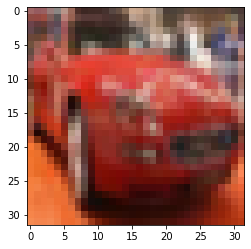

In [6]:
## check for one image
print('images shape ', train_dataset[0][0].shape)
index = 5
plt.imshow(torch.permute(train_dataset[index][0], (1, 2, 0)));

#### Build The Model

In [7]:
## 
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
        
        ## conv_base  ---> images input 3*32*32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        ## top_clf
        
        ## made flatten by yourself ---> 64 is the previuos channels --> 6x6 is window at this step
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=128)   ## 128 neurons
        self.fc2 = nn.Linear(in_features=128, out_features=64)       ## 64 neurons
        self.fc3 = nn.Linear(in_features=64, out_features=10)   ## 10 classes
        
        
    def forward(self, x):
        out = f.relu(self.conv1(x))
        out = self.pool1(out)
        out = f.relu(self.conv2(out))
        out = self.pool2(out)
        
        ## Flatten
        out = out.view(-1, 64*6*6)  ## ---> 64*6*6 (64, Channels, (6, 6) window) & -1 --? batch_size
        out = f.relu(self.fc1(out))
        out = f.relu(self.fc2(out))
        out = self.fc3(out)   ## for softmax --> No Activation function at the end
        return out

In [8]:
## Define the Model
model = ConvNeuralNetwork().to(device=device)

## Criteria
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


## Training
print('Training Started _____________________________________ \n')

n_iterations = len(train_loader)    ## --> = len(train_cifar)/n_batch_size
n_train_samples = 0
n_train_correct = 0

for epoch in range(n_epochs):
    print(f'## epoch No. {epoch+1}')
    for i, (train_images, train_labels) in enumerate(train_loader):
        
        ## images shape ---> batch_size * channels * height * width (32, 3, 32, 32)
        train_images = train_images.to(device=device)
        train_labels = train_labels.to(device=device)
        
        ## forward pass
        y_train_pred = model(train_images)
        ## loss
        l = loss(y_train_pred, train_labels)
        
        ## we can empty gradients first
        optimizer.zero_grad()
        ## backward
        l.backward()
        ## step
        optimizer.step()
        
        ## during training
        ## return value and index --> i care about index of max score
        _, y_train_pred_cls = torch.max(y_train_pred, dim=1)
        
        ## modify
        n_train_samples += train_labels.shape[0]
        n_train_correct += (y_train_pred_cls==train_labels).sum().item()
        train_accuracy = (n_train_correct/n_train_samples) * 100.0
        
        print(f'## Iteration No. {i+1}, loss={l:.5f}, acc={train_accuracy:.3f}')
        
print('Training is finished ___________________________')        

Training Started _____________________________________ 

## epoch No. 1
## Iteration No. 1, loss=2.29170, acc=6.250
## Iteration No. 2, loss=2.68495, acc=4.688
## Iteration No. 3, loss=2.28914, acc=6.250
## Iteration No. 4, loss=2.29702, acc=9.375
## Iteration No. 5, loss=2.38865, acc=9.375
## Iteration No. 6, loss=2.30978, acc=9.375
## Iteration No. 7, loss=2.30272, acc=9.375
## Iteration No. 8, loss=2.32133, acc=8.984
## Iteration No. 9, loss=2.31084, acc=9.375
## Iteration No. 10, loss=2.30525, acc=10.000
## Iteration No. 11, loss=2.28868, acc=9.943
## Iteration No. 12, loss=2.34679, acc=9.635
## Iteration No. 13, loss=2.29247, acc=9.856
## Iteration No. 14, loss=2.31689, acc=9.598
## Iteration No. 15, loss=2.26085, acc=10.208
## Iteration No. 16, loss=2.30787, acc=9.961
## Iteration No. 17, loss=2.27459, acc=10.294
## Iteration No. 18, loss=2.36026, acc=10.069
## Iteration No. 19, loss=2.28434, acc=10.197
## Iteration No. 20, loss=2.31794, acc=10.469
## Iteration No. 21, loss=2.301

## Iteration No. 178, loss=2.16450, acc=11.552
## Iteration No. 179, loss=2.23227, acc=11.540
## Iteration No. 180, loss=2.15427, acc=11.597
## Iteration No. 181, loss=2.11968, acc=11.550
## Iteration No. 182, loss=2.13647, acc=11.521
## Iteration No. 183, loss=2.13777, acc=11.561
## Iteration No. 184, loss=2.12358, acc=11.583
## Iteration No. 185, loss=2.00837, acc=11.672
## Iteration No. 186, loss=2.18494, acc=11.660
## Iteration No. 187, loss=2.21732, acc=11.664
## Iteration No. 188, loss=2.12260, acc=11.669
## Iteration No. 189, loss=2.05843, acc=11.739
## Iteration No. 190, loss=2.12435, acc=11.727
## Iteration No. 191, loss=2.08127, acc=11.715
## Iteration No. 192, loss=1.97705, acc=11.751
## Iteration No. 193, loss=2.12678, acc=11.820
## Iteration No. 194, loss=2.27337, acc=11.807
## Iteration No. 195, loss=2.24167, acc=11.843
## Iteration No. 196, loss=2.03894, acc=11.878
## Iteration No. 197, loss=2.22719, acc=11.913
## Iteration No. 198, loss=1.99168, acc=11.979
## Iteration 

## Iteration No. 353, loss=1.95879, acc=14.952
## Iteration No. 354, loss=1.94226, acc=14.963
## Iteration No. 355, loss=1.95078, acc=14.991
## Iteration No. 356, loss=2.11176, acc=14.975
## Iteration No. 357, loss=2.00125, acc=14.986
## Iteration No. 358, loss=1.74005, acc=15.031
## Iteration No. 359, loss=1.91683, acc=15.059
## Iteration No. 360, loss=1.84692, acc=15.104
## Iteration No. 361, loss=1.75990, acc=15.123
## Iteration No. 362, loss=1.92525, acc=15.116
## Iteration No. 363, loss=1.95511, acc=15.134
## Iteration No. 364, loss=1.85976, acc=15.144
## Iteration No. 365, loss=1.76658, acc=15.163
## Iteration No. 366, loss=1.77796, acc=15.181
## Iteration No. 367, loss=2.09633, acc=15.182
## Iteration No. 368, loss=1.78938, acc=15.226
## Iteration No. 369, loss=1.95032, acc=15.269
## Iteration No. 370, loss=1.91079, acc=15.287
## Iteration No. 371, loss=2.06294, acc=15.296
## Iteration No. 372, loss=2.09117, acc=15.297
## Iteration No. 373, loss=2.04306, acc=15.340
## Iteration 

## Iteration No. 531, loss=1.75312, acc=18.726
## Iteration No. 532, loss=2.06791, acc=18.732
## Iteration No. 533, loss=1.72698, acc=18.744
## Iteration No. 534, loss=1.80633, acc=18.768
## Iteration No. 535, loss=1.72764, acc=18.779
## Iteration No. 536, loss=1.82879, acc=18.785
## Iteration No. 537, loss=1.86612, acc=18.814
## Iteration No. 538, loss=1.80792, acc=18.831
## Iteration No. 539, loss=1.94353, acc=18.831
## Iteration No. 540, loss=1.88094, acc=18.843
## Iteration No. 541, loss=2.01923, acc=18.848
## Iteration No. 542, loss=1.95073, acc=18.865
## Iteration No. 543, loss=1.93445, acc=18.865
## Iteration No. 544, loss=1.89371, acc=18.894
## Iteration No. 545, loss=1.67440, acc=18.928
## Iteration No. 546, loss=1.93401, acc=18.933
## Iteration No. 547, loss=1.86119, acc=18.950
## Iteration No. 548, loss=1.79139, acc=18.978
## Iteration No. 549, loss=1.71675, acc=18.995
## Iteration No. 550, loss=1.76487, acc=19.006
## Iteration No. 551, loss=1.75611, acc=19.017
## Iteration 

## Iteration No. 708, loss=1.64273, acc=21.460
## Iteration No. 709, loss=1.84595, acc=21.456
## Iteration No. 710, loss=2.08662, acc=21.457
## Iteration No. 711, loss=1.99087, acc=21.462
## Iteration No. 712, loss=1.79798, acc=21.462
## Iteration No. 713, loss=1.87668, acc=21.472
## Iteration No. 714, loss=1.69974, acc=21.485
## Iteration No. 715, loss=1.81016, acc=21.499
## Iteration No. 716, loss=1.57181, acc=21.530
## Iteration No. 717, loss=1.65545, acc=21.548
## Iteration No. 718, loss=1.56765, acc=21.570
## Iteration No. 719, loss=1.89523, acc=21.579
## Iteration No. 720, loss=1.76881, acc=21.584
## Iteration No. 721, loss=1.69719, acc=21.602
## Iteration No. 722, loss=1.77672, acc=21.615
## Iteration No. 723, loss=1.71015, acc=21.611
## Iteration No. 724, loss=1.54909, acc=21.642
## Iteration No. 725, loss=1.68249, acc=21.655
## Iteration No. 726, loss=1.56615, acc=21.664
## Iteration No. 727, loss=2.36244, acc=21.647
## Iteration No. 728, loss=1.55281, acc=21.665
## Iteration 

## Iteration No. 885, loss=1.78261, acc=23.422
## Iteration No. 886, loss=1.77839, acc=23.409
## Iteration No. 887, loss=1.56095, acc=23.415
## Iteration No. 888, loss=1.81504, acc=23.427
## Iteration No. 889, loss=1.61923, acc=23.450
## Iteration No. 890, loss=1.87303, acc=23.462
## Iteration No. 891, loss=1.52640, acc=23.467
## Iteration No. 892, loss=1.75559, acc=23.476
## Iteration No. 893, loss=1.84836, acc=23.485
## Iteration No. 894, loss=1.50184, acc=23.497
## Iteration No. 895, loss=1.67951, acc=23.513
## Iteration No. 896, loss=1.66700, acc=23.511
## Iteration No. 897, loss=1.70358, acc=23.523
## Iteration No. 898, loss=1.91716, acc=23.521
## Iteration No. 899, loss=1.94500, acc=23.523
## Iteration No. 900, loss=1.65658, acc=23.528
## Iteration No. 901, loss=1.72479, acc=23.550
## Iteration No. 902, loss=1.86334, acc=23.552
## Iteration No. 903, loss=1.78510, acc=23.553
## Iteration No. 904, loss=1.95966, acc=23.548
## Iteration No. 905, loss=2.02533, acc=23.557
## Iteration 

## Iteration No. 1065, loss=1.79576, acc=25.085
## Iteration No. 1066, loss=1.99029, acc=25.106
## Iteration No. 1067, loss=1.63291, acc=25.120
## Iteration No. 1068, loss=1.78880, acc=25.138
## Iteration No. 1069, loss=1.48918, acc=25.152
## Iteration No. 1070, loss=1.71527, acc=25.158
## Iteration No. 1071, loss=1.68443, acc=25.160
## Iteration No. 1072, loss=1.98860, acc=25.160
## Iteration No. 1073, loss=1.92783, acc=25.169
## Iteration No. 1074, loss=1.70832, acc=25.175
## Iteration No. 1075, loss=1.50019, acc=25.201
## Iteration No. 1076, loss=1.74753, acc=25.209
## Iteration No. 1077, loss=1.63884, acc=25.218
## Iteration No. 1078, loss=1.49992, acc=25.235
## Iteration No. 1079, loss=1.72919, acc=25.246
## Iteration No. 1080, loss=1.78584, acc=25.252
## Iteration No. 1081, loss=1.87666, acc=25.257
## Iteration No. 1082, loss=1.74797, acc=25.269
## Iteration No. 1083, loss=1.49834, acc=25.271
## Iteration No. 1084, loss=1.79932, acc=25.274
## Iteration No. 1085, loss=1.67809, acc

## Iteration No. 1236, loss=1.67890, acc=26.509
## Iteration No. 1237, loss=1.97312, acc=26.503
## Iteration No. 1238, loss=1.69377, acc=26.509
## Iteration No. 1239, loss=1.31049, acc=26.533
## Iteration No. 1240, loss=1.54151, acc=26.542
## Iteration No. 1241, loss=1.84643, acc=26.549
## Iteration No. 1242, loss=1.61671, acc=26.550
## Iteration No. 1243, loss=1.66219, acc=26.554
## Iteration No. 1244, loss=1.55150, acc=26.560
## Iteration No. 1245, loss=1.42546, acc=26.571
## Iteration No. 1246, loss=1.58282, acc=26.575
## Iteration No. 1247, loss=1.52125, acc=26.581
## Iteration No. 1248, loss=1.63989, acc=26.590
## Iteration No. 1249, loss=1.72033, acc=26.589
## Iteration No. 1250, loss=1.59069, acc=26.600
## Iteration No. 1251, loss=1.55543, acc=26.619
## Iteration No. 1252, loss=1.48583, acc=26.637
## Iteration No. 1253, loss=1.97150, acc=26.649
## Iteration No. 1254, loss=1.75249, acc=26.655
## Iteration No. 1255, loss=1.90547, acc=26.661
## Iteration No. 1256, loss=1.81309, acc

## Iteration No. 1412, loss=1.85033, acc=27.638
## Iteration No. 1413, loss=1.59154, acc=27.656
## Iteration No. 1414, loss=1.68563, acc=27.661
## Iteration No. 1415, loss=1.58966, acc=27.668
## Iteration No. 1416, loss=1.55365, acc=27.668
## Iteration No. 1417, loss=1.65109, acc=27.677
## Iteration No. 1418, loss=1.44572, acc=27.695
## Iteration No. 1419, loss=1.76345, acc=27.709
## Iteration No. 1420, loss=1.76974, acc=27.718
## Iteration No. 1421, loss=1.67397, acc=27.718
## Iteration No. 1422, loss=1.46125, acc=27.723
## Iteration No. 1423, loss=1.45776, acc=27.730
## Iteration No. 1424, loss=2.03881, acc=27.723
## Iteration No. 1425, loss=1.76854, acc=27.737
## Iteration No. 1426, loss=1.54021, acc=27.752
## Iteration No. 1427, loss=1.60888, acc=27.755
## Iteration No. 1428, loss=1.43791, acc=27.764
## Iteration No. 1429, loss=1.66246, acc=27.764
## Iteration No. 1430, loss=1.66409, acc=27.769
## Iteration No. 1431, loss=1.51824, acc=27.782
## Iteration No. 1432, loss=1.53724, acc

## Iteration No. 26, loss=1.93288, acc=28.691
## Iteration No. 27, loss=1.60878, acc=28.698
## Iteration No. 28, loss=1.67949, acc=28.706
## Iteration No. 29, loss=1.79392, acc=28.707
## Iteration No. 30, loss=1.45219, acc=28.717
## Iteration No. 31, loss=1.57434, acc=28.728
## Iteration No. 32, loss=1.66505, acc=28.741
## Iteration No. 33, loss=1.86146, acc=28.745
## Iteration No. 34, loss=1.36384, acc=28.756
## Iteration No. 35, loss=1.51533, acc=28.758
## Iteration No. 36, loss=1.37834, acc=28.765
## Iteration No. 37, loss=1.70670, acc=28.769
## Iteration No. 38, loss=1.49142, acc=28.776
## Iteration No. 39, loss=1.63843, acc=28.784
## Iteration No. 40, loss=1.25358, acc=28.803
## Iteration No. 41, loss=1.72166, acc=28.804
## Iteration No. 42, loss=1.67318, acc=28.804
## Iteration No. 43, loss=1.80203, acc=28.803
## Iteration No. 44, loss=1.57111, acc=28.811
## Iteration No. 45, loss=1.54018, acc=28.816
## Iteration No. 46, loss=1.70711, acc=28.810
## Iteration No. 47, loss=1.92932,

## Iteration No. 204, loss=1.65857, acc=29.481
## Iteration No. 205, loss=1.60114, acc=29.491
## Iteration No. 206, loss=1.56151, acc=29.502
## Iteration No. 207, loss=1.81937, acc=29.503
## Iteration No. 208, loss=1.51349, acc=29.513
## Iteration No. 209, loss=1.71052, acc=29.514
## Iteration No. 210, loss=1.90062, acc=29.517
## Iteration No. 211, loss=1.78519, acc=29.513
## Iteration No. 212, loss=1.50868, acc=29.519
## Iteration No. 213, loss=1.46541, acc=29.527
## Iteration No. 214, loss=1.56314, acc=29.535
## Iteration No. 215, loss=1.70146, acc=29.536
## Iteration No. 216, loss=1.61394, acc=29.539
## Iteration No. 217, loss=1.54656, acc=29.547
## Iteration No. 218, loss=1.51268, acc=29.555
## Iteration No. 219, loss=1.50092, acc=29.564
## Iteration No. 220, loss=1.47739, acc=29.572
## Iteration No. 221, loss=1.49980, acc=29.582
## Iteration No. 222, loss=1.18444, acc=29.595
## Iteration No. 223, loss=1.67741, acc=29.600
## Iteration No. 224, loss=1.61508, acc=29.602
## Iteration 

## Iteration No. 385, loss=1.75813, acc=30.295
## Iteration No. 386, loss=1.44021, acc=30.302
## Iteration No. 387, loss=1.34624, acc=30.312
## Iteration No. 388, loss=1.47069, acc=30.311
## Iteration No. 389, loss=1.81620, acc=30.315
## Iteration No. 390, loss=1.65436, acc=30.312
## Iteration No. 391, loss=1.78166, acc=30.316
## Iteration No. 392, loss=1.75926, acc=30.319
## Iteration No. 393, loss=1.84830, acc=30.320
## Iteration No. 394, loss=1.87251, acc=30.316
## Iteration No. 395, loss=1.83745, acc=30.319
## Iteration No. 396, loss=1.88063, acc=30.323
## Iteration No. 397, loss=1.79780, acc=30.328
## Iteration No. 398, loss=1.70223, acc=30.327
## Iteration No. 399, loss=1.59133, acc=30.331
## Iteration No. 400, loss=1.37587, acc=30.338
## Iteration No. 401, loss=1.44838, acc=30.341
## Iteration No. 402, loss=1.74735, acc=30.343
## Iteration No. 403, loss=1.48682, acc=30.355
## Iteration No. 404, loss=1.60493, acc=30.362
## Iteration No. 405, loss=1.74522, acc=30.365
## Iteration 

## Iteration No. 560, loss=1.63439, acc=30.970
## Iteration No. 561, loss=1.49577, acc=30.979
## Iteration No. 562, loss=1.84880, acc=30.981
## Iteration No. 563, loss=1.43719, acc=30.988
## Iteration No. 564, loss=1.75552, acc=30.984
## Iteration No. 565, loss=1.93416, acc=30.983
## Iteration No. 566, loss=1.91689, acc=30.986
## Iteration No. 567, loss=1.65507, acc=30.984
## Iteration No. 568, loss=1.88004, acc=30.986
## Iteration No. 569, loss=1.45827, acc=30.992
## Iteration No. 570, loss=1.64672, acc=30.995
## Iteration No. 571, loss=1.67445, acc=31.001
## Iteration No. 572, loss=1.72621, acc=31.006
## Iteration No. 573, loss=1.61015, acc=31.010
## Iteration No. 574, loss=1.69614, acc=31.013
## Iteration No. 575, loss=1.48875, acc=31.018
## Iteration No. 576, loss=1.87885, acc=31.021
## Iteration No. 577, loss=1.56442, acc=31.028
## Iteration No. 578, loss=1.70832, acc=31.028
## Iteration No. 579, loss=1.65468, acc=31.030
## Iteration No. 580, loss=1.61730, acc=31.034
## Iteration 

## Iteration No. 741, loss=1.66530, acc=31.642
## Iteration No. 742, loss=1.85853, acc=31.646
## Iteration No. 743, loss=1.75618, acc=31.651
## Iteration No. 744, loss=1.61355, acc=31.650
## Iteration No. 745, loss=1.82914, acc=31.650
## Iteration No. 746, loss=1.57005, acc=31.651
## Iteration No. 747, loss=1.75564, acc=31.644
## Iteration No. 748, loss=1.72557, acc=31.646
## Iteration No. 749, loss=1.54428, acc=31.650
## Iteration No. 750, loss=1.51739, acc=31.655
## Iteration No. 751, loss=1.59203, acc=31.661
## Iteration No. 752, loss=1.63896, acc=31.666
## Iteration No. 753, loss=1.68513, acc=31.667
## Iteration No. 754, loss=1.61489, acc=31.672
## Iteration No. 755, loss=1.73382, acc=31.676
## Iteration No. 756, loss=1.52288, acc=31.679
## Iteration No. 757, loss=1.86008, acc=31.677
## Iteration No. 758, loss=1.56883, acc=31.682
## Iteration No. 759, loss=1.48037, acc=31.697
## Iteration No. 760, loss=1.95447, acc=31.697
## Iteration No. 761, loss=1.53922, acc=31.699
## Iteration 

## Iteration No. 921, loss=1.60524, acc=32.119
## Iteration No. 922, loss=1.59793, acc=32.125
## Iteration No. 923, loss=1.35675, acc=32.131
## Iteration No. 924, loss=1.72293, acc=32.127
## Iteration No. 925, loss=1.54409, acc=32.131
## Iteration No. 926, loss=1.51549, acc=32.135
## Iteration No. 927, loss=1.61595, acc=32.136
## Iteration No. 928, loss=1.62355, acc=32.142
## Iteration No. 929, loss=1.96528, acc=32.141
## Iteration No. 930, loss=1.49210, acc=32.144
## Iteration No. 931, loss=1.48536, acc=32.151
## Iteration No. 932, loss=1.78636, acc=32.151
## Iteration No. 933, loss=1.48063, acc=32.163
## Iteration No. 934, loss=1.72441, acc=32.164
## Iteration No. 935, loss=1.70433, acc=32.168
## Iteration No. 936, loss=1.79788, acc=32.167
## Iteration No. 937, loss=1.78782, acc=32.165
## Iteration No. 938, loss=1.25081, acc=32.171
## Iteration No. 939, loss=1.36034, acc=32.177
## Iteration No. 940, loss=1.58924, acc=32.179
## Iteration No. 941, loss=1.09367, acc=32.190
## Iteration 

## Iteration No. 1097, loss=1.49600, acc=32.590
## Iteration No. 1098, loss=1.68140, acc=32.590
## Iteration No. 1099, loss=1.78690, acc=32.589
## Iteration No. 1100, loss=1.62322, acc=32.592
## Iteration No. 1101, loss=1.52904, acc=32.597
## Iteration No. 1102, loss=1.33717, acc=32.603
## Iteration No. 1103, loss=1.49565, acc=32.609
## Iteration No. 1104, loss=1.67030, acc=32.608
## Iteration No. 1105, loss=1.61841, acc=32.609
## Iteration No. 1106, loss=1.54127, acc=32.615
## Iteration No. 1107, loss=1.42936, acc=32.620
## Iteration No. 1108, loss=1.34061, acc=32.624
## Iteration No. 1109, loss=2.10633, acc=32.619
## Iteration No. 1110, loss=1.50452, acc=32.618
## Iteration No. 1111, loss=1.78747, acc=32.618
## Iteration No. 1112, loss=1.51495, acc=32.621
## Iteration No. 1113, loss=1.29610, acc=32.628
## Iteration No. 1114, loss=1.67686, acc=32.631
## Iteration No. 1115, loss=1.79090, acc=32.632
## Iteration No. 1116, loss=1.70245, acc=32.634
## Iteration No. 1117, loss=1.37222, acc

## Iteration No. 1268, loss=1.57815, acc=33.022
## Iteration No. 1269, loss=1.64662, acc=33.025
## Iteration No. 1270, loss=1.47979, acc=33.034
## Iteration No. 1271, loss=1.60229, acc=33.038
## Iteration No. 1272, loss=1.71837, acc=33.043
## Iteration No. 1273, loss=1.93019, acc=33.044
## Iteration No. 1274, loss=1.26063, acc=33.051
## Iteration No. 1275, loss=1.62926, acc=33.052
## Iteration No. 1276, loss=1.62040, acc=33.050
## Iteration No. 1277, loss=1.66356, acc=33.053
## Iteration No. 1278, loss=1.65693, acc=33.052
## Iteration No. 1279, loss=1.72222, acc=33.049
## Iteration No. 1280, loss=1.39796, acc=33.051
## Iteration No. 1281, loss=1.65551, acc=33.055
## Iteration No. 1282, loss=1.60192, acc=33.054
## Iteration No. 1283, loss=1.50451, acc=33.055
## Iteration No. 1284, loss=1.65891, acc=33.057
## Iteration No. 1285, loss=1.67729, acc=33.061
## Iteration No. 1286, loss=1.62942, acc=33.062
## Iteration No. 1287, loss=1.64730, acc=33.068
## Iteration No. 1288, loss=1.42721, acc

## Iteration No. 1439, loss=1.37870, acc=33.420
## Iteration No. 1440, loss=1.57731, acc=33.426
## Iteration No. 1441, loss=1.41048, acc=33.432
## Iteration No. 1442, loss=1.83200, acc=33.432
## Iteration No. 1443, loss=1.73400, acc=33.437
## Iteration No. 1444, loss=1.77443, acc=33.438
## Iteration No. 1445, loss=1.46665, acc=33.441
## Iteration No. 1446, loss=1.46711, acc=33.443
## Iteration No. 1447, loss=1.26940, acc=33.448
## Iteration No. 1448, loss=1.61360, acc=33.451
## Iteration No. 1449, loss=1.54389, acc=33.452
## Iteration No. 1450, loss=1.56031, acc=33.454
## Iteration No. 1451, loss=1.69368, acc=33.455
## Iteration No. 1452, loss=1.65269, acc=33.458
## Iteration No. 1453, loss=1.43058, acc=33.460
## Iteration No. 1454, loss=1.71487, acc=33.464
## Iteration No. 1455, loss=1.42467, acc=33.465
## Iteration No. 1456, loss=1.38157, acc=33.470
## Iteration No. 1457, loss=1.75665, acc=33.471
## Iteration No. 1458, loss=1.43157, acc=33.476
## Iteration No. 1459, loss=1.59622, acc

## Iteration No. 51, loss=1.51179, acc=33.863
## Iteration No. 52, loss=1.68123, acc=33.865
## Iteration No. 53, loss=1.64035, acc=33.868
## Iteration No. 54, loss=1.43767, acc=33.872
## Iteration No. 55, loss=1.13275, acc=33.878
## Iteration No. 56, loss=1.50298, acc=33.883
## Iteration No. 57, loss=1.45464, acc=33.889
## Iteration No. 58, loss=1.47841, acc=33.892
## Iteration No. 59, loss=1.59573, acc=33.895
## Iteration No. 60, loss=1.55723, acc=33.894
## Iteration No. 61, loss=1.44084, acc=33.897
## Iteration No. 62, loss=1.82774, acc=33.895
## Iteration No. 63, loss=1.80012, acc=33.892
## Iteration No. 64, loss=1.67163, acc=33.896
## Iteration No. 65, loss=1.62324, acc=33.897
## Iteration No. 66, loss=1.90741, acc=33.894
## Iteration No. 67, loss=1.67886, acc=33.892
## Iteration No. 68, loss=1.77161, acc=33.891
## Iteration No. 69, loss=1.70944, acc=33.891
## Iteration No. 70, loss=1.45842, acc=33.892
## Iteration No. 71, loss=1.67040, acc=33.894
## Iteration No. 72, loss=1.68741,

## Iteration No. 227, loss=1.73806, acc=34.254
## Iteration No. 228, loss=1.66828, acc=34.254
## Iteration No. 229, loss=1.38334, acc=34.260
## Iteration No. 230, loss=1.43672, acc=34.265
## Iteration No. 231, loss=1.40189, acc=34.271
## Iteration No. 232, loss=1.68355, acc=34.270
## Iteration No. 233, loss=1.75135, acc=34.270
## Iteration No. 234, loss=1.64052, acc=34.273
## Iteration No. 235, loss=1.38714, acc=34.278
## Iteration No. 236, loss=1.35099, acc=34.281
## Iteration No. 237, loss=1.54450, acc=34.284
## Iteration No. 238, loss=1.39100, acc=34.290
## Iteration No. 239, loss=2.11785, acc=34.290
## Iteration No. 240, loss=1.55039, acc=34.290
## Iteration No. 241, loss=1.65137, acc=34.292
## Iteration No. 242, loss=1.46781, acc=34.295
## Iteration No. 243, loss=1.63977, acc=34.300
## Iteration No. 244, loss=1.57258, acc=34.300
## Iteration No. 245, loss=1.55285, acc=34.300
## Iteration No. 246, loss=1.77623, acc=34.303
## Iteration No. 247, loss=1.61756, acc=34.305
## Iteration 

## Iteration No. 403, loss=1.54110, acc=34.735
## Iteration No. 404, loss=1.59409, acc=34.736
## Iteration No. 405, loss=1.84606, acc=34.734
## Iteration No. 406, loss=1.60532, acc=34.735
## Iteration No. 407, loss=1.60511, acc=34.740
## Iteration No. 408, loss=1.58688, acc=34.744
## Iteration No. 409, loss=1.65836, acc=34.745
## Iteration No. 410, loss=1.79767, acc=34.743
## Iteration No. 411, loss=1.24257, acc=34.751
## Iteration No. 412, loss=1.49161, acc=34.756
## Iteration No. 413, loss=1.33969, acc=34.761
## Iteration No. 414, loss=1.73985, acc=34.761
## Iteration No. 415, loss=1.58650, acc=34.763
## Iteration No. 416, loss=1.60665, acc=34.763
## Iteration No. 417, loss=1.43381, acc=34.765
## Iteration No. 418, loss=1.69496, acc=34.764
## Iteration No. 419, loss=1.30428, acc=34.768
## Iteration No. 420, loss=1.62646, acc=34.771
## Iteration No. 421, loss=1.55646, acc=34.773
## Iteration No. 422, loss=1.18899, acc=34.781
## Iteration No. 423, loss=1.46023, acc=34.783
## Iteration 

## Iteration No. 578, loss=1.57177, acc=35.102
## Iteration No. 579, loss=1.57481, acc=35.105
## Iteration No. 580, loss=1.57101, acc=35.108
## Iteration No. 581, loss=1.48095, acc=35.111
## Iteration No. 582, loss=1.88426, acc=35.110
## Iteration No. 583, loss=1.18425, acc=35.114
## Iteration No. 584, loss=1.74712, acc=35.111
## Iteration No. 585, loss=1.60773, acc=35.110
## Iteration No. 586, loss=1.55804, acc=35.112
## Iteration No. 587, loss=1.87192, acc=35.112
## Iteration No. 588, loss=1.70222, acc=35.112
## Iteration No. 589, loss=1.46202, acc=35.117
## Iteration No. 590, loss=1.61593, acc=35.120
## Iteration No. 591, loss=1.37914, acc=35.122
## Iteration No. 592, loss=1.47941, acc=35.125
## Iteration No. 593, loss=1.23694, acc=35.129
## Iteration No. 594, loss=1.74623, acc=35.129
## Iteration No. 595, loss=1.56560, acc=35.132
## Iteration No. 596, loss=1.74065, acc=35.137
## Iteration No. 597, loss=1.44683, acc=35.141
## Iteration No. 598, loss=1.58160, acc=35.142
## Iteration 

## Iteration No. 753, loss=2.02416, acc=35.397
## Iteration No. 754, loss=1.64552, acc=35.397
## Iteration No. 755, loss=1.87014, acc=35.395
## Iteration No. 756, loss=1.52927, acc=35.399
## Iteration No. 757, loss=1.77903, acc=35.399
## Iteration No. 758, loss=1.31124, acc=35.404
## Iteration No. 759, loss=1.28899, acc=35.410
## Iteration No. 760, loss=1.45212, acc=35.411
## Iteration No. 761, loss=1.41998, acc=35.416
## Iteration No. 762, loss=1.86140, acc=35.415
## Iteration No. 763, loss=1.66710, acc=35.415
## Iteration No. 764, loss=1.59788, acc=35.416
## Iteration No. 765, loss=1.55997, acc=35.415
## Iteration No. 766, loss=1.66555, acc=35.417
## Iteration No. 767, loss=1.47781, acc=35.419
## Iteration No. 768, loss=1.44688, acc=35.422
## Iteration No. 769, loss=1.26365, acc=35.425
## Iteration No. 770, loss=1.53732, acc=35.427
## Iteration No. 771, loss=1.35972, acc=35.430
## Iteration No. 772, loss=1.51628, acc=35.435
## Iteration No. 773, loss=1.44478, acc=35.438
## Iteration 

## Iteration No. 929, loss=1.21501, acc=35.739
## Iteration No. 930, loss=1.47775, acc=35.741
## Iteration No. 931, loss=1.45793, acc=35.746
## Iteration No. 932, loss=1.64592, acc=35.746
## Iteration No. 933, loss=1.53971, acc=35.750
## Iteration No. 934, loss=1.56439, acc=35.752
## Iteration No. 935, loss=1.20105, acc=35.758
## Iteration No. 936, loss=1.44460, acc=35.761
## Iteration No. 937, loss=1.36933, acc=35.768
## Iteration No. 938, loss=1.72355, acc=35.771
## Iteration No. 939, loss=1.72183, acc=35.770
## Iteration No. 940, loss=1.45403, acc=35.770
## Iteration No. 941, loss=1.32810, acc=35.775
## Iteration No. 942, loss=1.49849, acc=35.774
## Iteration No. 943, loss=1.73653, acc=35.772
## Iteration No. 944, loss=1.86807, acc=35.773
## Iteration No. 945, loss=1.52002, acc=35.774
## Iteration No. 946, loss=1.81488, acc=35.777
## Iteration No. 947, loss=1.59726, acc=35.778
## Iteration No. 948, loss=1.38118, acc=35.783
## Iteration No. 949, loss=1.51976, acc=35.785
## Iteration 

## Iteration No. 1105, loss=1.37077, acc=36.068
## Iteration No. 1106, loss=1.36058, acc=36.073
## Iteration No. 1107, loss=1.18014, acc=36.080
## Iteration No. 1108, loss=1.66563, acc=36.086
## Iteration No. 1109, loss=1.63211, acc=36.085
## Iteration No. 1110, loss=1.53030, acc=36.086
## Iteration No. 1111, loss=1.73701, acc=36.086
## Iteration No. 1112, loss=1.66238, acc=36.088
## Iteration No. 1113, loss=1.52390, acc=36.089
## Iteration No. 1114, loss=2.05822, acc=36.089
## Iteration No. 1115, loss=1.50761, acc=36.091
## Iteration No. 1116, loss=1.82642, acc=36.092
## Iteration No. 1117, loss=1.31960, acc=36.096
## Iteration No. 1118, loss=1.47448, acc=36.097
## Iteration No. 1119, loss=2.00048, acc=36.094
## Iteration No. 1120, loss=1.58117, acc=36.095
## Iteration No. 1121, loss=1.69324, acc=36.099
## Iteration No. 1122, loss=1.95455, acc=36.100
## Iteration No. 1123, loss=1.42935, acc=36.102
## Iteration No. 1124, loss=1.57290, acc=36.102
## Iteration No. 1125, loss=1.75539, acc

## Iteration No. 1276, loss=1.28322, acc=36.334
## Iteration No. 1277, loss=1.50278, acc=36.335
## Iteration No. 1278, loss=1.68335, acc=36.336
## Iteration No. 1279, loss=1.76727, acc=36.336
## Iteration No. 1280, loss=1.58275, acc=36.336
## Iteration No. 1281, loss=1.16841, acc=36.343
## Iteration No. 1282, loss=1.47705, acc=36.347
## Iteration No. 1283, loss=1.62913, acc=36.347
## Iteration No. 1284, loss=1.73107, acc=36.348
## Iteration No. 1285, loss=1.69345, acc=36.349
## Iteration No. 1286, loss=1.54538, acc=36.349
## Iteration No. 1287, loss=2.00420, acc=36.348
## Iteration No. 1288, loss=1.53017, acc=36.353
## Iteration No. 1289, loss=1.51675, acc=36.355
## Iteration No. 1290, loss=1.70856, acc=36.355
## Iteration No. 1291, loss=1.67845, acc=36.354
## Iteration No. 1292, loss=1.60636, acc=36.355
## Iteration No. 1293, loss=1.62216, acc=36.356
## Iteration No. 1294, loss=1.61991, acc=36.358
## Iteration No. 1295, loss=1.47257, acc=36.360
## Iteration No. 1296, loss=1.21996, acc

## Iteration No. 1447, loss=1.39414, acc=36.613
## Iteration No. 1448, loss=1.28858, acc=36.618
## Iteration No. 1449, loss=1.61106, acc=36.619
## Iteration No. 1450, loss=1.86663, acc=36.620
## Iteration No. 1451, loss=1.45493, acc=36.620
## Iteration No. 1452, loss=1.45939, acc=36.625
## Iteration No. 1453, loss=1.54528, acc=36.627
## Iteration No. 1454, loss=1.29773, acc=36.629
## Iteration No. 1455, loss=1.13596, acc=36.635
## Iteration No. 1456, loss=1.60463, acc=36.636
## Iteration No. 1457, loss=1.38495, acc=36.638
## Iteration No. 1458, loss=1.56933, acc=36.638
## Iteration No. 1459, loss=1.47208, acc=36.638
## Iteration No. 1460, loss=1.58428, acc=36.641
## Iteration No. 1461, loss=1.36944, acc=36.644
## Iteration No. 1462, loss=1.28027, acc=36.650
## Iteration No. 1463, loss=1.21196, acc=36.653
## Iteration No. 1464, loss=1.66059, acc=36.655
## Iteration No. 1465, loss=1.55425, acc=36.656
## Iteration No. 1466, loss=1.79585, acc=36.652
## Iteration No. 1467, loss=1.49078, acc

## Iteration No. 58, loss=1.42706, acc=36.869
## Iteration No. 59, loss=1.85752, acc=36.869
## Iteration No. 60, loss=1.27567, acc=36.873
## Iteration No. 61, loss=1.31146, acc=36.876
## Iteration No. 62, loss=1.22644, acc=36.878
## Iteration No. 63, loss=1.49569, acc=36.880
## Iteration No. 64, loss=1.35654, acc=36.881
## Iteration No. 65, loss=1.60184, acc=36.883
## Iteration No. 66, loss=1.94972, acc=36.880
## Iteration No. 67, loss=1.34946, acc=36.884
## Iteration No. 68, loss=1.24218, acc=36.888
## Iteration No. 69, loss=1.54223, acc=36.886
## Iteration No. 70, loss=1.60736, acc=36.888
## Iteration No. 71, loss=1.54681, acc=36.891
## Iteration No. 72, loss=1.40197, acc=36.893
## Iteration No. 73, loss=1.48948, acc=36.891
## Iteration No. 74, loss=1.29398, acc=36.894
## Iteration No. 75, loss=1.55726, acc=36.896
## Iteration No. 76, loss=1.42949, acc=36.896
## Iteration No. 77, loss=1.64955, acc=36.897
## Iteration No. 78, loss=1.47851, acc=36.901
## Iteration No. 79, loss=1.50274,

## Iteration No. 236, loss=1.73182, acc=37.159
## Iteration No. 237, loss=1.56761, acc=37.159
## Iteration No. 238, loss=1.70955, acc=37.161
## Iteration No. 239, loss=1.42213, acc=37.163
## Iteration No. 240, loss=1.56489, acc=37.164
## Iteration No. 241, loss=1.14702, acc=37.170
## Iteration No. 242, loss=1.68621, acc=37.172
## Iteration No. 243, loss=1.67680, acc=37.171
## Iteration No. 244, loss=1.68150, acc=37.170
## Iteration No. 245, loss=1.38046, acc=37.173
## Iteration No. 246, loss=1.44074, acc=37.174
## Iteration No. 247, loss=1.63628, acc=37.174
## Iteration No. 248, loss=1.42157, acc=37.177
## Iteration No. 249, loss=1.68850, acc=37.178
## Iteration No. 250, loss=1.47626, acc=37.179
## Iteration No. 251, loss=1.36379, acc=37.183
## Iteration No. 252, loss=1.40064, acc=37.184
## Iteration No. 253, loss=1.83232, acc=37.182
## Iteration No. 254, loss=1.76027, acc=37.181
## Iteration No. 255, loss=1.15721, acc=37.185
## Iteration No. 256, loss=1.54751, acc=37.186
## Iteration 

## Iteration No. 414, loss=1.71187, acc=37.392
## Iteration No. 415, loss=1.25797, acc=37.395
## Iteration No. 416, loss=1.77747, acc=37.395
## Iteration No. 417, loss=1.58954, acc=37.397
## Iteration No. 418, loss=1.61288, acc=37.396
## Iteration No. 419, loss=1.29072, acc=37.400
## Iteration No. 420, loss=1.27574, acc=37.401
## Iteration No. 421, loss=1.45114, acc=37.403
## Iteration No. 422, loss=1.65195, acc=37.403
## Iteration No. 423, loss=1.53867, acc=37.404
## Iteration No. 424, loss=1.53831, acc=37.407
## Iteration No. 425, loss=1.80135, acc=37.406
## Iteration No. 426, loss=1.50948, acc=37.404
## Iteration No. 427, loss=1.25292, acc=37.407
## Iteration No. 428, loss=1.66065, acc=37.408
## Iteration No. 429, loss=1.27471, acc=37.411
## Iteration No. 430, loss=1.66510, acc=37.415
## Iteration No. 431, loss=1.68242, acc=37.415
## Iteration No. 432, loss=1.42148, acc=37.416
## Iteration No. 433, loss=1.66055, acc=37.416
## Iteration No. 434, loss=1.54576, acc=37.418
## Iteration 

## Iteration No. 594, loss=1.24586, acc=37.649
## Iteration No. 595, loss=1.62995, acc=37.650
## Iteration No. 596, loss=1.48814, acc=37.653
## Iteration No. 597, loss=1.54476, acc=37.653
## Iteration No. 598, loss=1.25885, acc=37.655
## Iteration No. 599, loss=1.60722, acc=37.656
## Iteration No. 600, loss=1.28579, acc=37.660
## Iteration No. 601, loss=1.78221, acc=37.658
## Iteration No. 602, loss=1.41322, acc=37.659
## Iteration No. 603, loss=1.44625, acc=37.659
## Iteration No. 604, loss=1.42311, acc=37.662
## Iteration No. 605, loss=1.51747, acc=37.665
## Iteration No. 606, loss=1.64104, acc=37.666
## Iteration No. 607, loss=1.58578, acc=37.666
## Iteration No. 608, loss=1.07854, acc=37.671
## Iteration No. 609, loss=1.46832, acc=37.670
## Iteration No. 610, loss=1.82883, acc=37.670
## Iteration No. 611, loss=1.55463, acc=37.670
## Iteration No. 612, loss=1.46174, acc=37.673
## Iteration No. 613, loss=1.60012, acc=37.675
## Iteration No. 614, loss=1.56261, acc=37.675
## Iteration 

## Iteration No. 774, loss=1.69635, acc=37.872
## Iteration No. 775, loss=1.42840, acc=37.878
## Iteration No. 776, loss=1.51228, acc=37.880
## Iteration No. 777, loss=1.50120, acc=37.881
## Iteration No. 778, loss=1.13602, acc=37.886
## Iteration No. 779, loss=1.60801, acc=37.889
## Iteration No. 780, loss=1.48647, acc=37.890
## Iteration No. 781, loss=1.55489, acc=37.892
## Iteration No. 782, loss=1.72344, acc=37.893
## Iteration No. 783, loss=1.63273, acc=37.891
## Iteration No. 784, loss=1.33897, acc=37.894
## Iteration No. 785, loss=1.57525, acc=37.894
## Iteration No. 786, loss=1.60926, acc=37.895
## Iteration No. 787, loss=1.51117, acc=37.897
## Iteration No. 788, loss=1.71960, acc=37.896
## Iteration No. 789, loss=1.46009, acc=37.899
## Iteration No. 790, loss=1.55041, acc=37.899
## Iteration No. 791, loss=1.88790, acc=37.900
## Iteration No. 792, loss=1.37970, acc=37.902
## Iteration No. 793, loss=1.47360, acc=37.903
## Iteration No. 794, loss=1.49966, acc=37.904
## Iteration 

## Iteration No. 952, loss=1.74867, acc=38.093
## Iteration No. 953, loss=1.73719, acc=38.095
## Iteration No. 954, loss=1.57231, acc=38.097
## Iteration No. 955, loss=1.72275, acc=38.098
## Iteration No. 956, loss=1.29273, acc=38.101
## Iteration No. 957, loss=1.63094, acc=38.101
## Iteration No. 958, loss=1.46481, acc=38.101
## Iteration No. 959, loss=1.31532, acc=38.103
## Iteration No. 960, loss=1.34550, acc=38.105
## Iteration No. 961, loss=1.09424, acc=38.110
## Iteration No. 962, loss=1.57023, acc=38.112
## Iteration No. 963, loss=1.77324, acc=38.112
## Iteration No. 964, loss=1.36371, acc=38.113
## Iteration No. 965, loss=1.58737, acc=38.114
## Iteration No. 966, loss=1.36454, acc=38.114
## Iteration No. 967, loss=1.40482, acc=38.116
## Iteration No. 968, loss=1.37814, acc=38.117
## Iteration No. 969, loss=1.84298, acc=38.118
## Iteration No. 970, loss=1.50430, acc=38.120
## Iteration No. 971, loss=1.55420, acc=38.121
## Iteration No. 972, loss=1.59830, acc=38.121
## Iteration 

## Iteration No. 1128, loss=1.44029, acc=38.346
## Iteration No. 1129, loss=1.59911, acc=38.346
## Iteration No. 1130, loss=1.63646, acc=38.346
## Iteration No. 1131, loss=1.52036, acc=38.349
## Iteration No. 1132, loss=1.32483, acc=38.350
## Iteration No. 1133, loss=1.33054, acc=38.353
## Iteration No. 1134, loss=1.23595, acc=38.357
## Iteration No. 1135, loss=1.83657, acc=38.358
## Iteration No. 1136, loss=1.56905, acc=38.358
## Iteration No. 1137, loss=1.31359, acc=38.361
## Iteration No. 1138, loss=1.32788, acc=38.362
## Iteration No. 1139, loss=1.54545, acc=38.362
## Iteration No. 1140, loss=1.58385, acc=38.362
## Iteration No. 1141, loss=1.37456, acc=38.363
## Iteration No. 1142, loss=1.64883, acc=38.364
## Iteration No. 1143, loss=1.43550, acc=38.363
## Iteration No. 1144, loss=1.31258, acc=38.365
## Iteration No. 1145, loss=1.65371, acc=38.365
## Iteration No. 1146, loss=1.56770, acc=38.365
## Iteration No. 1147, loss=1.35986, acc=38.367
## Iteration No. 1148, loss=1.44711, acc

## Iteration No. 1301, loss=1.76447, acc=38.555
## Iteration No. 1302, loss=1.73613, acc=38.555
## Iteration No. 1303, loss=1.94246, acc=38.554
## Iteration No. 1304, loss=1.57756, acc=38.553
## Iteration No. 1305, loss=1.33439, acc=38.555
## Iteration No. 1306, loss=1.38332, acc=38.555
## Iteration No. 1307, loss=1.32894, acc=38.559
## Iteration No. 1308, loss=1.61477, acc=38.560
## Iteration No. 1309, loss=1.28864, acc=38.563
## Iteration No. 1310, loss=1.60697, acc=38.564
## Iteration No. 1311, loss=1.14572, acc=38.568
## Iteration No. 1312, loss=1.59061, acc=38.570
## Iteration No. 1313, loss=1.44371, acc=38.571
## Iteration No. 1314, loss=1.52041, acc=38.572
## Iteration No. 1315, loss=1.24639, acc=38.575
## Iteration No. 1316, loss=1.28170, acc=38.577
## Iteration No. 1317, loss=1.59393, acc=38.579
## Iteration No. 1318, loss=1.42663, acc=38.581
## Iteration No. 1319, loss=1.10537, acc=38.585
## Iteration No. 1320, loss=1.57774, acc=38.584
## Iteration No. 1321, loss=1.44699, acc

## Iteration No. 1472, loss=1.47563, acc=38.763
## Iteration No. 1473, loss=1.83512, acc=38.762
## Iteration No. 1474, loss=1.77509, acc=38.762
## Iteration No. 1475, loss=1.53914, acc=38.763
## Iteration No. 1476, loss=1.29296, acc=38.765
## Iteration No. 1477, loss=1.24649, acc=38.767
## Iteration No. 1478, loss=1.54992, acc=38.770
## Iteration No. 1479, loss=1.44348, acc=38.770
## Iteration No. 1480, loss=1.79740, acc=38.771
## Iteration No. 1481, loss=1.82717, acc=38.771
## Iteration No. 1482, loss=1.45954, acc=38.770
## Iteration No. 1483, loss=1.57386, acc=38.772
## Iteration No. 1484, loss=1.34667, acc=38.775
## Iteration No. 1485, loss=1.47339, acc=38.776
## Iteration No. 1486, loss=1.86559, acc=38.775
## Iteration No. 1487, loss=1.71042, acc=38.773
## Iteration No. 1488, loss=1.23184, acc=38.778
## Iteration No. 1489, loss=1.23205, acc=38.780
## Iteration No. 1490, loss=2.03393, acc=38.779
## Iteration No. 1491, loss=1.31408, acc=38.782
## Iteration No. 1492, loss=1.82650, acc

## Iteration No. 86, loss=1.55137, acc=38.980
## Iteration No. 87, loss=1.36252, acc=38.981
## Iteration No. 88, loss=1.58203, acc=38.983
## Iteration No. 89, loss=1.34491, acc=38.985
## Iteration No. 90, loss=1.32730, acc=38.989
## Iteration No. 91, loss=1.47151, acc=38.989
## Iteration No. 92, loss=1.32997, acc=38.992
## Iteration No. 93, loss=0.98383, acc=38.996
## Iteration No. 94, loss=1.19054, acc=38.998
## Iteration No. 95, loss=1.76259, acc=38.998
## Iteration No. 96, loss=1.36254, acc=38.998
## Iteration No. 97, loss=1.32643, acc=39.001
## Iteration No. 98, loss=1.49186, acc=39.002
## Iteration No. 99, loss=1.34252, acc=39.004
## Iteration No. 100, loss=1.62922, acc=39.003
## Iteration No. 101, loss=1.78409, acc=39.004
## Iteration No. 102, loss=1.78394, acc=39.003
## Iteration No. 103, loss=1.81619, acc=39.003
## Iteration No. 104, loss=1.23708, acc=39.004
## Iteration No. 105, loss=1.31842, acc=39.008
## Iteration No. 106, loss=1.41433, acc=39.009
## Iteration No. 107, loss=

## Iteration No. 266, loss=1.55399, acc=39.221
## Iteration No. 267, loss=1.52924, acc=39.222
## Iteration No. 268, loss=1.58651, acc=39.222
## Iteration No. 269, loss=1.53436, acc=39.221
## Iteration No. 270, loss=1.61087, acc=39.223
## Iteration No. 271, loss=1.52412, acc=39.224
## Iteration No. 272, loss=1.65945, acc=39.221
## Iteration No. 273, loss=1.78314, acc=39.222
## Iteration No. 274, loss=1.92885, acc=39.222
## Iteration No. 275, loss=1.68909, acc=39.222
## Iteration No. 276, loss=1.46350, acc=39.224
## Iteration No. 277, loss=1.38122, acc=39.226
## Iteration No. 278, loss=1.55613, acc=39.228
## Iteration No. 279, loss=1.74175, acc=39.228
## Iteration No. 280, loss=2.00708, acc=39.227
## Iteration No. 281, loss=1.60122, acc=39.227
## Iteration No. 282, loss=1.95168, acc=39.228
## Iteration No. 283, loss=1.69742, acc=39.227
## Iteration No. 284, loss=1.64677, acc=39.227
## Iteration No. 285, loss=1.72176, acc=39.227
## Iteration No. 286, loss=1.38380, acc=39.227
## Iteration 

## Iteration No. 444, loss=1.15947, acc=39.400
## Iteration No. 445, loss=1.27089, acc=39.403
## Iteration No. 446, loss=1.28038, acc=39.405
## Iteration No. 447, loss=1.69675, acc=39.406
## Iteration No. 448, loss=1.57601, acc=39.408
## Iteration No. 449, loss=1.50054, acc=39.409
## Iteration No. 450, loss=1.35887, acc=39.412
## Iteration No. 451, loss=1.68116, acc=39.412
## Iteration No. 452, loss=1.35498, acc=39.414
## Iteration No. 453, loss=1.42504, acc=39.415
## Iteration No. 454, loss=1.47440, acc=39.415
## Iteration No. 455, loss=1.54639, acc=39.416
## Iteration No. 456, loss=1.47628, acc=39.418
## Iteration No. 457, loss=1.14487, acc=39.421
## Iteration No. 458, loss=1.40066, acc=39.421
## Iteration No. 459, loss=1.51804, acc=39.422
## Iteration No. 460, loss=1.27940, acc=39.425
## Iteration No. 461, loss=1.46919, acc=39.425
## Iteration No. 462, loss=1.50431, acc=39.426
## Iteration No. 463, loss=1.43176, acc=39.428
## Iteration No. 464, loss=1.74912, acc=39.429
## Iteration 

## Iteration No. 622, loss=1.56339, acc=39.577
## Iteration No. 623, loss=1.07612, acc=39.580
## Iteration No. 624, loss=1.47809, acc=39.581
## Iteration No. 625, loss=1.80267, acc=39.579
## Iteration No. 626, loss=1.48232, acc=39.579
## Iteration No. 627, loss=1.86968, acc=39.578
## Iteration No. 628, loss=1.64558, acc=39.578
## Iteration No. 629, loss=1.45670, acc=39.579
## Iteration No. 630, loss=1.51134, acc=39.579
## Iteration No. 631, loss=1.47751, acc=39.581
## Iteration No. 632, loss=1.18520, acc=39.584
## Iteration No. 633, loss=1.51207, acc=39.585
## Iteration No. 634, loss=1.66660, acc=39.585
## Iteration No. 635, loss=1.66367, acc=39.585
## Iteration No. 636, loss=1.39023, acc=39.587
## Iteration No. 637, loss=1.42932, acc=39.586
## Iteration No. 638, loss=1.26564, acc=39.589
## Iteration No. 639, loss=1.73519, acc=39.588
## Iteration No. 640, loss=1.46270, acc=39.590
## Iteration No. 641, loss=1.67421, acc=39.589
## Iteration No. 642, loss=1.27846, acc=39.590
## Iteration 

## Iteration No. 802, loss=1.33944, acc=39.747
## Iteration No. 803, loss=1.38394, acc=39.749
## Iteration No. 804, loss=1.54320, acc=39.751
## Iteration No. 805, loss=1.33073, acc=39.752
## Iteration No. 806, loss=1.45487, acc=39.754
## Iteration No. 807, loss=1.44844, acc=39.755
## Iteration No. 808, loss=1.41131, acc=39.755
## Iteration No. 809, loss=1.44944, acc=39.756
## Iteration No. 810, loss=2.16612, acc=39.753
## Iteration No. 811, loss=1.30265, acc=39.754
## Iteration No. 812, loss=1.25241, acc=39.757
## Iteration No. 813, loss=1.27236, acc=39.758
## Iteration No. 814, loss=1.69803, acc=39.759
## Iteration No. 815, loss=1.21708, acc=39.762
## Iteration No. 816, loss=1.15331, acc=39.764
## Iteration No. 817, loss=1.44315, acc=39.765
## Iteration No. 818, loss=1.51482, acc=39.766
## Iteration No. 819, loss=1.69559, acc=39.766
## Iteration No. 820, loss=1.36714, acc=39.767
## Iteration No. 821, loss=1.43269, acc=39.768
## Iteration No. 822, loss=1.52998, acc=39.767
## Iteration 

## Iteration No. 983, loss=1.28327, acc=39.941
## Iteration No. 984, loss=1.61069, acc=39.941
## Iteration No. 985, loss=1.60032, acc=39.941
## Iteration No. 986, loss=1.49772, acc=39.941
## Iteration No. 987, loss=1.72373, acc=39.940
## Iteration No. 988, loss=1.21149, acc=39.942
## Iteration No. 989, loss=1.74826, acc=39.942
## Iteration No. 990, loss=1.57855, acc=39.943
## Iteration No. 991, loss=1.29602, acc=39.945
## Iteration No. 992, loss=1.66596, acc=39.944
## Iteration No. 993, loss=1.38807, acc=39.945
## Iteration No. 994, loss=1.36492, acc=39.946
## Iteration No. 995, loss=1.17321, acc=39.949
## Iteration No. 996, loss=1.33640, acc=39.951
## Iteration No. 997, loss=1.62918, acc=39.951
## Iteration No. 998, loss=1.71009, acc=39.951
## Iteration No. 999, loss=0.91505, acc=39.956
## Iteration No. 1000, loss=1.83162, acc=39.955
## Iteration No. 1001, loss=1.58332, acc=39.953
## Iteration No. 1002, loss=1.53816, acc=39.954
## Iteration No. 1003, loss=1.58265, acc=39.955
## Iterat

## Iteration No. 1156, loss=1.36880, acc=40.114
## Iteration No. 1157, loss=1.60232, acc=40.113
## Iteration No. 1158, loss=1.57831, acc=40.114
## Iteration No. 1159, loss=1.49041, acc=40.117
## Iteration No. 1160, loss=1.72385, acc=40.117
## Iteration No. 1161, loss=1.40595, acc=40.116
## Iteration No. 1162, loss=1.25429, acc=40.119
## Iteration No. 1163, loss=1.49941, acc=40.119
## Iteration No. 1164, loss=1.53057, acc=40.118
## Iteration No. 1165, loss=1.29997, acc=40.119
## Iteration No. 1166, loss=1.27721, acc=40.121
## Iteration No. 1167, loss=1.49411, acc=40.122
## Iteration No. 1168, loss=1.43720, acc=40.122
## Iteration No. 1169, loss=1.67709, acc=40.122
## Iteration No. 1170, loss=1.49617, acc=40.124
## Iteration No. 1171, loss=1.28676, acc=40.126
## Iteration No. 1172, loss=1.53393, acc=40.126
## Iteration No. 1173, loss=1.20706, acc=40.127
## Iteration No. 1174, loss=1.32949, acc=40.129
## Iteration No. 1175, loss=1.46525, acc=40.130
## Iteration No. 1176, loss=1.55901, acc

## Iteration No. 1330, loss=1.39218, acc=40.237
## Iteration No. 1331, loss=1.35803, acc=40.239
## Iteration No. 1332, loss=1.39329, acc=40.239
## Iteration No. 1333, loss=1.38452, acc=40.241
## Iteration No. 1334, loss=1.36503, acc=40.242
## Iteration No. 1335, loss=1.14588, acc=40.245
## Iteration No. 1336, loss=1.42535, acc=40.246
## Iteration No. 1337, loss=1.27575, acc=40.248
## Iteration No. 1338, loss=1.42242, acc=40.249
## Iteration No. 1339, loss=1.23047, acc=40.251
## Iteration No. 1340, loss=1.41565, acc=40.251
## Iteration No. 1341, loss=1.40550, acc=40.252
## Iteration No. 1342, loss=1.48654, acc=40.252
## Iteration No. 1343, loss=1.74964, acc=40.252
## Iteration No. 1344, loss=1.47404, acc=40.253
## Iteration No. 1345, loss=1.07769, acc=40.256
## Iteration No. 1346, loss=1.38072, acc=40.257
## Iteration No. 1347, loss=1.16244, acc=40.258
## Iteration No. 1348, loss=1.73809, acc=40.258
## Iteration No. 1349, loss=1.46791, acc=40.258
## Iteration No. 1350, loss=1.44875, acc

## Iteration No. 1504, loss=1.59726, acc=40.390
## Iteration No. 1505, loss=1.69833, acc=40.389
## Iteration No. 1506, loss=1.66950, acc=40.388
## Iteration No. 1507, loss=1.61747, acc=40.388
## Iteration No. 1508, loss=1.59665, acc=40.389
## Iteration No. 1509, loss=1.43146, acc=40.391
## Iteration No. 1510, loss=1.78887, acc=40.390
## Iteration No. 1511, loss=1.44906, acc=40.392
## Iteration No. 1512, loss=1.76499, acc=40.392
## Iteration No. 1513, loss=1.06837, acc=40.394
## Iteration No. 1514, loss=1.44220, acc=40.395
## Iteration No. 1515, loss=1.36492, acc=40.396
## Iteration No. 1516, loss=1.28158, acc=40.398
## Iteration No. 1517, loss=1.67229, acc=40.397
## Iteration No. 1518, loss=1.44752, acc=40.398
## Iteration No. 1519, loss=1.56202, acc=40.398
## Iteration No. 1520, loss=1.39475, acc=40.401
## Iteration No. 1521, loss=1.31088, acc=40.402
## Iteration No. 1522, loss=1.18664, acc=40.404
## Iteration No. 1523, loss=1.40992, acc=40.405
## Iteration No. 1524, loss=1.42499, acc

## Iteration No. 122, loss=1.58807, acc=40.574
## Iteration No. 123, loss=1.06756, acc=40.577
## Iteration No. 124, loss=1.17767, acc=40.579
## Iteration No. 125, loss=1.49964, acc=40.580
## Iteration No. 126, loss=1.56944, acc=40.580
## Iteration No. 127, loss=1.89274, acc=40.579
## Iteration No. 128, loss=1.82866, acc=40.578
## Iteration No. 129, loss=1.50538, acc=40.580
## Iteration No. 130, loss=1.97025, acc=40.579
## Iteration No. 131, loss=1.86522, acc=40.579
## Iteration No. 132, loss=1.52978, acc=40.580
## Iteration No. 133, loss=1.70921, acc=40.578
## Iteration No. 134, loss=1.99560, acc=40.578
## Iteration No. 135, loss=1.48873, acc=40.578
## Iteration No. 136, loss=1.55855, acc=40.577
## Iteration No. 137, loss=1.45210, acc=40.576
## Iteration No. 138, loss=1.57933, acc=40.575
## Iteration No. 139, loss=1.50822, acc=40.576
## Iteration No. 140, loss=1.50994, acc=40.575
## Iteration No. 141, loss=1.60253, acc=40.576
## Iteration No. 142, loss=1.41258, acc=40.575
## Iteration 

## Iteration No. 299, loss=1.29091, acc=40.712
## Iteration No. 300, loss=1.48721, acc=40.713
## Iteration No. 301, loss=1.58838, acc=40.714
## Iteration No. 302, loss=1.31074, acc=40.715
## Iteration No. 303, loss=1.15976, acc=40.717
## Iteration No. 304, loss=1.50326, acc=40.716
## Iteration No. 305, loss=1.54895, acc=40.716
## Iteration No. 306, loss=1.33743, acc=40.718
## Iteration No. 307, loss=1.40124, acc=40.721
## Iteration No. 308, loss=1.27064, acc=40.721
## Iteration No. 309, loss=1.54822, acc=40.723
## Iteration No. 310, loss=1.71855, acc=40.721
## Iteration No. 311, loss=1.38804, acc=40.723
## Iteration No. 312, loss=1.40766, acc=40.724
## Iteration No. 313, loss=1.17933, acc=40.727
## Iteration No. 314, loss=1.68460, acc=40.726
## Iteration No. 315, loss=1.38633, acc=40.727
## Iteration No. 316, loss=1.73941, acc=40.727
## Iteration No. 317, loss=1.20141, acc=40.729
## Iteration No. 318, loss=1.32907, acc=40.731
## Iteration No. 319, loss=1.54636, acc=40.731
## Iteration 

## Iteration No. 475, loss=1.50028, acc=40.868
## Iteration No. 476, loss=1.02995, acc=40.870
## Iteration No. 477, loss=1.88714, acc=40.869
## Iteration No. 478, loss=1.06149, acc=40.872
## Iteration No. 479, loss=1.36043, acc=40.874
## Iteration No. 480, loss=1.35059, acc=40.875
## Iteration No. 481, loss=1.48224, acc=40.874
## Iteration No. 482, loss=1.10737, acc=40.876
## Iteration No. 483, loss=1.68615, acc=40.877
## Iteration No. 484, loss=1.57894, acc=40.876
## Iteration No. 485, loss=1.37477, acc=40.877
## Iteration No. 486, loss=1.75669, acc=40.878
## Iteration No. 487, loss=1.54530, acc=40.879
## Iteration No. 488, loss=1.00334, acc=40.881
## Iteration No. 489, loss=1.37284, acc=40.883
## Iteration No. 490, loss=1.41972, acc=40.883
## Iteration No. 491, loss=1.46398, acc=40.885
## Iteration No. 492, loss=1.77559, acc=40.886
## Iteration No. 493, loss=1.49278, acc=40.886
## Iteration No. 494, loss=1.31148, acc=40.889
## Iteration No. 495, loss=1.48043, acc=40.889
## Iteration 

## Iteration No. 653, loss=1.42404, acc=41.024
## Iteration No. 654, loss=1.63446, acc=41.023
## Iteration No. 655, loss=1.62858, acc=41.025
## Iteration No. 656, loss=1.40899, acc=41.024
## Iteration No. 657, loss=1.37589, acc=41.026
## Iteration No. 658, loss=1.72029, acc=41.026
## Iteration No. 659, loss=1.62210, acc=41.026
## Iteration No. 660, loss=1.65984, acc=41.026
## Iteration No. 661, loss=1.62418, acc=41.026
## Iteration No. 662, loss=1.63161, acc=41.027
## Iteration No. 663, loss=1.84660, acc=41.027
## Iteration No. 664, loss=2.03121, acc=41.027
## Iteration No. 665, loss=1.37044, acc=41.028
## Iteration No. 666, loss=1.70175, acc=41.028
## Iteration No. 667, loss=1.65308, acc=41.028
## Iteration No. 668, loss=1.44927, acc=41.028
## Iteration No. 669, loss=1.54560, acc=41.030
## Iteration No. 670, loss=1.56863, acc=41.031
## Iteration No. 671, loss=1.32040, acc=41.031
## Iteration No. 672, loss=1.56608, acc=41.032
## Iteration No. 673, loss=1.56024, acc=41.031
## Iteration 

## Iteration No. 834, loss=1.52168, acc=41.161
## Iteration No. 835, loss=1.36328, acc=41.163
## Iteration No. 836, loss=1.32442, acc=41.166
## Iteration No. 837, loss=1.43875, acc=41.166
## Iteration No. 838, loss=1.59607, acc=41.167
## Iteration No. 839, loss=1.63589, acc=41.167
## Iteration No. 840, loss=1.78808, acc=41.167
## Iteration No. 841, loss=1.85925, acc=41.166
## Iteration No. 842, loss=1.44382, acc=41.167
## Iteration No. 843, loss=1.38490, acc=41.167
## Iteration No. 844, loss=1.80461, acc=41.167
## Iteration No. 845, loss=1.48945, acc=41.168
## Iteration No. 846, loss=1.52646, acc=41.169
## Iteration No. 847, loss=1.71709, acc=41.168
## Iteration No. 848, loss=1.70839, acc=41.167
## Iteration No. 849, loss=1.34888, acc=41.168
## Iteration No. 850, loss=1.09457, acc=41.172
## Iteration No. 851, loss=1.73750, acc=41.172
## Iteration No. 852, loss=1.32200, acc=41.173
## Iteration No. 853, loss=1.37506, acc=41.174
## Iteration No. 854, loss=1.38171, acc=41.175
## Iteration 

## Iteration No. 1013, loss=1.33156, acc=41.282
## Iteration No. 1014, loss=1.61125, acc=41.282
## Iteration No. 1015, loss=1.25202, acc=41.284
## Iteration No. 1016, loss=1.57257, acc=41.284
## Iteration No. 1017, loss=1.27401, acc=41.286
## Iteration No. 1018, loss=1.34249, acc=41.287
## Iteration No. 1019, loss=1.24021, acc=41.289
## Iteration No. 1020, loss=1.41039, acc=41.289
## Iteration No. 1021, loss=1.39800, acc=41.289
## Iteration No. 1022, loss=1.46494, acc=41.291
## Iteration No. 1023, loss=1.67368, acc=41.291
## Iteration No. 1024, loss=1.44958, acc=41.292
## Iteration No. 1025, loss=1.66755, acc=41.292
## Iteration No. 1026, loss=1.29289, acc=41.293
## Iteration No. 1027, loss=1.33270, acc=41.296
## Iteration No. 1028, loss=1.69610, acc=41.295
## Iteration No. 1029, loss=1.49668, acc=41.295
## Iteration No. 1030, loss=1.35071, acc=41.296
## Iteration No. 1031, loss=1.28760, acc=41.297
## Iteration No. 1032, loss=1.65054, acc=41.297
## Iteration No. 1033, loss=1.54382, acc

## Iteration No. 1185, loss=1.46108, acc=41.390
## Iteration No. 1186, loss=1.17624, acc=41.391
## Iteration No. 1187, loss=1.58675, acc=41.392
## Iteration No. 1188, loss=1.64792, acc=41.391
## Iteration No. 1189, loss=1.68404, acc=41.390
## Iteration No. 1190, loss=1.41871, acc=41.391
## Iteration No. 1191, loss=1.33767, acc=41.391
## Iteration No. 1192, loss=1.52691, acc=41.391
## Iteration No. 1193, loss=1.45147, acc=41.392
## Iteration No. 1194, loss=1.58292, acc=41.392
## Iteration No. 1195, loss=1.74838, acc=41.392
## Iteration No. 1196, loss=1.35434, acc=41.393
## Iteration No. 1197, loss=1.34781, acc=41.394
## Iteration No. 1198, loss=1.48478, acc=41.395
## Iteration No. 1199, loss=1.27804, acc=41.397
## Iteration No. 1200, loss=1.72011, acc=41.396
## Iteration No. 1201, loss=1.39790, acc=41.397
## Iteration No. 1202, loss=1.15540, acc=41.398
## Iteration No. 1203, loss=1.28557, acc=41.399
## Iteration No. 1204, loss=2.06309, acc=41.397
## Iteration No. 1205, loss=1.51375, acc

## Iteration No. 1359, loss=1.40880, acc=41.508
## Iteration No. 1360, loss=1.76978, acc=41.507
## Iteration No. 1361, loss=1.72788, acc=41.508
## Iteration No. 1362, loss=1.52290, acc=41.508
## Iteration No. 1363, loss=1.67888, acc=41.508
## Iteration No. 1364, loss=1.34898, acc=41.509
## Iteration No. 1365, loss=1.34436, acc=41.510
## Iteration No. 1366, loss=1.42874, acc=41.512
## Iteration No. 1367, loss=1.16317, acc=41.513
## Iteration No. 1368, loss=1.31060, acc=41.515
## Iteration No. 1369, loss=1.49158, acc=41.516
## Iteration No. 1370, loss=1.38614, acc=41.517
## Iteration No. 1371, loss=1.36704, acc=41.517
## Iteration No. 1372, loss=1.19676, acc=41.518
## Iteration No. 1373, loss=1.41145, acc=41.519
## Iteration No. 1374, loss=1.49670, acc=41.519
## Iteration No. 1375, loss=1.16750, acc=41.521
## Iteration No. 1376, loss=1.23754, acc=41.522
## Iteration No. 1377, loss=1.34407, acc=41.524
## Iteration No. 1378, loss=1.37749, acc=41.525
## Iteration No. 1379, loss=1.58543, acc

## Iteration No. 1532, loss=1.51697, acc=41.630
## Iteration No. 1533, loss=1.56062, acc=41.630
## Iteration No. 1534, loss=1.43212, acc=41.632
## Iteration No. 1535, loss=1.46715, acc=41.631
## Iteration No. 1536, loss=1.64050, acc=41.630
## Iteration No. 1537, loss=1.46942, acc=41.630
## Iteration No. 1538, loss=1.56507, acc=41.631
## Iteration No. 1539, loss=1.56863, acc=41.632
## Iteration No. 1540, loss=1.50365, acc=41.632
## Iteration No. 1541, loss=1.29282, acc=41.634
## Iteration No. 1542, loss=1.47274, acc=41.634
## Iteration No. 1543, loss=1.55541, acc=41.635
## Iteration No. 1544, loss=1.43170, acc=41.635
## Iteration No. 1545, loss=1.46672, acc=41.636
## Iteration No. 1546, loss=1.52152, acc=41.637
## Iteration No. 1547, loss=1.73183, acc=41.637
## Iteration No. 1548, loss=1.19345, acc=41.640
## Iteration No. 1549, loss=1.51719, acc=41.641
## Iteration No. 1550, loss=1.26787, acc=41.642
## Iteration No. 1551, loss=1.69882, acc=41.642
## Iteration No. 1552, loss=1.17603, acc

## Iteration No. 145, loss=1.44074, acc=41.768
## Iteration No. 146, loss=1.51149, acc=41.769
## Iteration No. 147, loss=1.26327, acc=41.769
## Iteration No. 148, loss=1.14198, acc=41.771
## Iteration No. 149, loss=1.17110, acc=41.773
## Iteration No. 150, loss=1.57997, acc=41.774
## Iteration No. 151, loss=1.33564, acc=41.776
## Iteration No. 152, loss=1.52136, acc=41.776
## Iteration No. 153, loss=1.82071, acc=41.775
## Iteration No. 154, loss=1.60310, acc=41.775
## Iteration No. 155, loss=1.60284, acc=41.776
## Iteration No. 156, loss=1.81467, acc=41.776
## Iteration No. 157, loss=1.40203, acc=41.776
## Iteration No. 158, loss=1.42564, acc=41.778
## Iteration No. 159, loss=1.94493, acc=41.776
## Iteration No. 160, loss=1.50573, acc=41.777
## Iteration No. 161, loss=1.80045, acc=41.776
## Iteration No. 162, loss=1.47935, acc=41.776
## Iteration No. 163, loss=1.46674, acc=41.776
## Iteration No. 164, loss=1.65923, acc=41.777
## Iteration No. 165, loss=1.36166, acc=41.779
## Iteration 

## Iteration No. 323, loss=1.40304, acc=41.873
## Iteration No. 324, loss=1.20915, acc=41.875
## Iteration No. 325, loss=1.98912, acc=41.873
## Iteration No. 326, loss=1.29382, acc=41.875
## Iteration No. 327, loss=1.46811, acc=41.876
## Iteration No. 328, loss=0.86413, acc=41.879
## Iteration No. 329, loss=1.36315, acc=41.880
## Iteration No. 330, loss=1.25864, acc=41.881
## Iteration No. 331, loss=1.15345, acc=41.883
## Iteration No. 332, loss=1.51175, acc=41.883
## Iteration No. 333, loss=1.98014, acc=41.883
## Iteration No. 334, loss=1.50529, acc=41.883
## Iteration No. 335, loss=1.51129, acc=41.883
## Iteration No. 336, loss=1.36226, acc=41.884
## Iteration No. 337, loss=1.60891, acc=41.884
## Iteration No. 338, loss=1.36901, acc=41.885
## Iteration No. 339, loss=1.29693, acc=41.885
## Iteration No. 340, loss=1.54240, acc=41.884
## Iteration No. 341, loss=1.45196, acc=41.886
## Iteration No. 342, loss=1.56039, acc=41.886
## Iteration No. 343, loss=1.36917, acc=41.887
## Iteration 

## Iteration No. 503, loss=1.45510, acc=41.988
## Iteration No. 504, loss=1.74703, acc=41.987
## Iteration No. 505, loss=1.54103, acc=41.988
## Iteration No. 506, loss=1.57505, acc=41.989
## Iteration No. 507, loss=1.39315, acc=41.990
## Iteration No. 508, loss=1.45117, acc=41.989
## Iteration No. 509, loss=1.30141, acc=41.990
## Iteration No. 510, loss=1.49493, acc=41.990
## Iteration No. 511, loss=1.43707, acc=41.991
## Iteration No. 512, loss=1.24762, acc=41.993
## Iteration No. 513, loss=1.36887, acc=41.993
## Iteration No. 514, loss=1.53300, acc=41.994
## Iteration No. 515, loss=1.44945, acc=41.995
## Iteration No. 516, loss=1.09454, acc=41.997
## Iteration No. 517, loss=1.36150, acc=41.998
## Iteration No. 518, loss=1.54861, acc=41.999
## Iteration No. 519, loss=1.42918, acc=42.000
## Iteration No. 520, loss=2.37605, acc=42.000
## Iteration No. 521, loss=1.11723, acc=42.002
## Iteration No. 522, loss=1.44304, acc=42.001
## Iteration No. 523, loss=1.28075, acc=42.002
## Iteration 

## Iteration No. 680, loss=1.37259, acc=42.108
## Iteration No. 681, loss=1.30630, acc=42.108
## Iteration No. 682, loss=1.28405, acc=42.109
## Iteration No. 683, loss=1.24085, acc=42.110
## Iteration No. 684, loss=1.11553, acc=42.112
## Iteration No. 685, loss=1.52713, acc=42.113
## Iteration No. 686, loss=1.66096, acc=42.113
## Iteration No. 687, loss=1.65346, acc=42.113
## Iteration No. 688, loss=1.19089, acc=42.114
## Iteration No. 689, loss=1.11492, acc=42.116
## Iteration No. 690, loss=1.08438, acc=42.117
## Iteration No. 691, loss=1.45114, acc=42.119
## Iteration No. 692, loss=1.84926, acc=42.118
## Iteration No. 693, loss=1.36071, acc=42.119
## Iteration No. 694, loss=1.59759, acc=42.119
## Iteration No. 695, loss=1.33453, acc=42.120
## Iteration No. 696, loss=1.69080, acc=42.121
## Iteration No. 697, loss=1.72951, acc=42.121
## Iteration No. 698, loss=1.54857, acc=42.121
## Iteration No. 699, loss=1.39400, acc=42.122
## Iteration No. 700, loss=1.25926, acc=42.123
## Iteration 

## Iteration No. 857, loss=1.59012, acc=42.210
## Iteration No. 858, loss=1.47580, acc=42.211
## Iteration No. 859, loss=1.47936, acc=42.211
## Iteration No. 860, loss=1.55708, acc=42.211
## Iteration No. 861, loss=1.25337, acc=42.212
## Iteration No. 862, loss=2.06243, acc=42.210
## Iteration No. 863, loss=1.19541, acc=42.212
## Iteration No. 864, loss=1.34185, acc=42.214
## Iteration No. 865, loss=1.59008, acc=42.214
## Iteration No. 866, loss=1.45297, acc=42.215
## Iteration No. 867, loss=1.34535, acc=42.217
## Iteration No. 868, loss=1.37515, acc=42.217
## Iteration No. 869, loss=2.20035, acc=42.216
## Iteration No. 870, loss=1.55183, acc=42.215
## Iteration No. 871, loss=1.45921, acc=42.215
## Iteration No. 872, loss=1.40514, acc=42.216
## Iteration No. 873, loss=1.28598, acc=42.217
## Iteration No. 874, loss=2.03212, acc=42.216
## Iteration No. 875, loss=1.69186, acc=42.216
## Iteration No. 876, loss=1.21214, acc=42.218
## Iteration No. 877, loss=1.34172, acc=42.218
## Iteration 

## Iteration No. 1037, loss=1.48903, acc=42.309
## Iteration No. 1038, loss=2.01672, acc=42.309
## Iteration No. 1039, loss=1.35339, acc=42.310
## Iteration No. 1040, loss=0.99229, acc=42.312
## Iteration No. 1041, loss=1.91513, acc=42.311
## Iteration No. 1042, loss=1.84264, acc=42.311
## Iteration No. 1043, loss=1.53011, acc=42.311
## Iteration No. 1044, loss=1.26915, acc=42.313
## Iteration No. 1045, loss=1.51929, acc=42.314
## Iteration No. 1046, loss=1.77916, acc=42.314
## Iteration No. 1047, loss=1.41081, acc=42.315
## Iteration No. 1048, loss=1.23809, acc=42.316
## Iteration No. 1049, loss=1.58805, acc=42.316
## Iteration No. 1050, loss=1.53032, acc=42.317
## Iteration No. 1051, loss=1.33969, acc=42.317
## Iteration No. 1052, loss=1.36220, acc=42.317
## Iteration No. 1053, loss=1.33001, acc=42.318
## Iteration No. 1054, loss=1.30491, acc=42.319
## Iteration No. 1055, loss=1.31179, acc=42.321
## Iteration No. 1056, loss=1.04385, acc=42.323
## Iteration No. 1057, loss=1.27244, acc

## Iteration No. 1210, loss=1.21837, acc=42.405
## Iteration No. 1211, loss=1.59564, acc=42.405
## Iteration No. 1212, loss=1.51017, acc=42.406
## Iteration No. 1213, loss=1.59968, acc=42.406
## Iteration No. 1214, loss=1.48221, acc=42.406
## Iteration No. 1215, loss=1.69672, acc=42.405
## Iteration No. 1216, loss=1.14224, acc=42.407
## Iteration No. 1217, loss=1.23226, acc=42.408
## Iteration No. 1218, loss=1.50921, acc=42.409
## Iteration No. 1219, loss=1.54855, acc=42.409
## Iteration No. 1220, loss=1.63558, acc=42.409
## Iteration No. 1221, loss=1.05439, acc=42.411
## Iteration No. 1222, loss=1.40827, acc=42.411
## Iteration No. 1223, loss=1.54482, acc=42.411
## Iteration No. 1224, loss=1.32459, acc=42.412
## Iteration No. 1225, loss=1.52299, acc=42.412
## Iteration No. 1226, loss=1.82415, acc=42.412
## Iteration No. 1227, loss=1.59338, acc=42.412
## Iteration No. 1228, loss=1.24030, acc=42.413
## Iteration No. 1229, loss=1.68865, acc=42.414
## Iteration No. 1230, loss=1.82849, acc

## Iteration No. 1385, loss=1.70063, acc=42.487
## Iteration No. 1386, loss=1.43542, acc=42.487
## Iteration No. 1387, loss=1.31293, acc=42.488
## Iteration No. 1388, loss=1.75287, acc=42.488
## Iteration No. 1389, loss=1.19666, acc=42.489
## Iteration No. 1390, loss=1.61495, acc=42.489
## Iteration No. 1391, loss=1.30454, acc=42.490
## Iteration No. 1392, loss=1.45969, acc=42.489
## Iteration No. 1393, loss=1.24574, acc=42.490
## Iteration No. 1394, loss=1.38456, acc=42.491
## Iteration No. 1395, loss=1.62153, acc=42.491
## Iteration No. 1396, loss=1.23362, acc=42.492
## Iteration No. 1397, loss=1.13441, acc=42.494
## Iteration No. 1398, loss=1.40901, acc=42.494
## Iteration No. 1399, loss=1.08320, acc=42.496
## Iteration No. 1400, loss=1.64574, acc=42.495
## Iteration No. 1401, loss=1.48917, acc=42.495
## Iteration No. 1402, loss=1.54698, acc=42.496
## Iteration No. 1403, loss=1.40340, acc=42.497
## Iteration No. 1404, loss=1.53130, acc=42.496
## Iteration No. 1405, loss=1.44092, acc

## Iteration No. 1561, loss=1.33917, acc=42.579
## Iteration No. 1562, loss=1.25515, acc=42.580
## Iteration No. 1563, loss=1.49921, acc=42.581
## epoch No. 8
## Iteration No. 1, loss=1.15149, acc=42.582
## Iteration No. 2, loss=1.22165, acc=42.583
## Iteration No. 3, loss=1.48149, acc=42.583
## Iteration No. 4, loss=1.44732, acc=42.584
## Iteration No. 5, loss=1.64193, acc=42.584
## Iteration No. 6, loss=1.64003, acc=42.584
## Iteration No. 7, loss=1.71639, acc=42.584
## Iteration No. 8, loss=1.33820, acc=42.585
## Iteration No. 9, loss=1.12745, acc=42.586
## Iteration No. 10, loss=1.59794, acc=42.586
## Iteration No. 11, loss=1.21023, acc=42.588
## Iteration No. 12, loss=1.43448, acc=42.589
## Iteration No. 13, loss=1.84720, acc=42.588
## Iteration No. 14, loss=1.54883, acc=42.589
## Iteration No. 15, loss=1.45290, acc=42.589
## Iteration No. 16, loss=1.36005, acc=42.590
## Iteration No. 17, loss=1.42088, acc=42.590
## Iteration No. 18, loss=1.23047, acc=42.591
## Iteration No. 19, l

## Iteration No. 182, loss=1.00360, acc=42.685
## Iteration No. 183, loss=1.60396, acc=42.684
## Iteration No. 184, loss=0.99038, acc=42.686
## Iteration No. 185, loss=1.28409, acc=42.686
## Iteration No. 186, loss=1.60963, acc=42.686
## Iteration No. 187, loss=1.74180, acc=42.685
## Iteration No. 188, loss=1.66540, acc=42.685
## Iteration No. 189, loss=1.56073, acc=42.685
## Iteration No. 190, loss=1.63189, acc=42.686
## Iteration No. 191, loss=1.22088, acc=42.687
## Iteration No. 192, loss=1.75425, acc=42.687
## Iteration No. 193, loss=1.65536, acc=42.688
## Iteration No. 194, loss=1.33793, acc=42.689
## Iteration No. 195, loss=1.48738, acc=42.689
## Iteration No. 196, loss=1.41374, acc=42.692
## Iteration No. 197, loss=1.23602, acc=42.693
## Iteration No. 198, loss=1.43688, acc=42.693
## Iteration No. 199, loss=1.35441, acc=42.694
## Iteration No. 200, loss=1.39844, acc=42.693
## Iteration No. 201, loss=1.41652, acc=42.695
## Iteration No. 202, loss=1.06940, acc=42.696
## Iteration 

## Iteration No. 357, loss=1.21367, acc=42.789
## Iteration No. 358, loss=1.57758, acc=42.789
## Iteration No. 359, loss=1.44569, acc=42.790
## Iteration No. 360, loss=1.26631, acc=42.791
## Iteration No. 361, loss=1.14798, acc=42.792
## Iteration No. 362, loss=1.54282, acc=42.792
## Iteration No. 363, loss=1.33112, acc=42.793
## Iteration No. 364, loss=1.16396, acc=42.794
## Iteration No. 365, loss=1.36029, acc=42.794
## Iteration No. 366, loss=1.12615, acc=42.795
## Iteration No. 367, loss=0.77407, acc=42.798
## Iteration No. 368, loss=1.33962, acc=42.799
## Iteration No. 369, loss=1.31071, acc=42.800
## Iteration No. 370, loss=1.47325, acc=42.800
## Iteration No. 371, loss=1.37088, acc=42.802
## Iteration No. 372, loss=1.47021, acc=42.801
## Iteration No. 373, loss=1.00488, acc=42.804
## Iteration No. 374, loss=1.67167, acc=42.804
## Iteration No. 375, loss=1.04327, acc=42.806
## Iteration No. 376, loss=1.21004, acc=42.807
## Iteration No. 377, loss=0.96042, acc=42.809
## Iteration 

## Iteration No. 533, loss=1.88059, acc=42.911
## Iteration No. 534, loss=1.27236, acc=42.912
## Iteration No. 535, loss=1.36267, acc=42.912
## Iteration No. 536, loss=1.43590, acc=42.913
## Iteration No. 537, loss=1.70337, acc=42.912
## Iteration No. 538, loss=1.34291, acc=42.913
## Iteration No. 539, loss=1.23483, acc=42.915
## Iteration No. 540, loss=1.35909, acc=42.915
## Iteration No. 541, loss=1.22803, acc=42.917
## Iteration No. 542, loss=1.03942, acc=42.919
## Iteration No. 543, loss=1.15770, acc=42.921
## Iteration No. 544, loss=1.19612, acc=42.922
## Iteration No. 545, loss=1.52647, acc=42.922
## Iteration No. 546, loss=1.40762, acc=42.923
## Iteration No. 547, loss=1.31599, acc=42.923
## Iteration No. 548, loss=1.49472, acc=42.923
## Iteration No. 549, loss=1.19850, acc=42.924
## Iteration No. 550, loss=1.18019, acc=42.926
## Iteration No. 551, loss=1.70630, acc=42.925
## Iteration No. 552, loss=1.27107, acc=42.926
## Iteration No. 553, loss=1.44840, acc=42.926
## Iteration 

## Iteration No. 709, loss=1.67653, acc=43.028
## Iteration No. 710, loss=1.39901, acc=43.028
## Iteration No. 711, loss=1.22045, acc=43.029
## Iteration No. 712, loss=1.32975, acc=43.031
## Iteration No. 713, loss=1.57772, acc=43.031
## Iteration No. 714, loss=1.51938, acc=43.030
## Iteration No. 715, loss=1.12544, acc=43.032
## Iteration No. 716, loss=1.31358, acc=43.033
## Iteration No. 717, loss=1.09717, acc=43.035
## Iteration No. 718, loss=1.48804, acc=43.035
## Iteration No. 719, loss=1.56412, acc=43.035
## Iteration No. 720, loss=1.59564, acc=43.034
## Iteration No. 721, loss=1.48317, acc=43.034
## Iteration No. 722, loss=1.78644, acc=43.034
## Iteration No. 723, loss=1.10743, acc=43.036
## Iteration No. 724, loss=1.57926, acc=43.036
## Iteration No. 725, loss=1.18627, acc=43.038
## Iteration No. 726, loss=1.29795, acc=43.038
## Iteration No. 727, loss=1.68851, acc=43.037
## Iteration No. 728, loss=1.18146, acc=43.039
## Iteration No. 729, loss=1.55795, acc=43.039
## Iteration 

## Iteration No. 885, loss=1.73196, acc=43.113
## Iteration No. 886, loss=1.54898, acc=43.113
## Iteration No. 887, loss=1.37556, acc=43.114
## Iteration No. 888, loss=1.48609, acc=43.114
## Iteration No. 889, loss=1.43707, acc=43.115
## Iteration No. 890, loss=1.60691, acc=43.114
## Iteration No. 891, loss=1.55890, acc=43.115
## Iteration No. 892, loss=1.31492, acc=43.115
## Iteration No. 893, loss=1.15036, acc=43.116
## Iteration No. 894, loss=1.39856, acc=43.117
## Iteration No. 895, loss=1.72410, acc=43.117
## Iteration No. 896, loss=1.31279, acc=43.116
## Iteration No. 897, loss=1.43451, acc=43.117
## Iteration No. 898, loss=1.02765, acc=43.119
## Iteration No. 899, loss=1.37532, acc=43.121
## Iteration No. 900, loss=1.64442, acc=43.121
## Iteration No. 901, loss=1.25203, acc=43.123
## Iteration No. 902, loss=1.24097, acc=43.124
## Iteration No. 903, loss=1.23265, acc=43.125
## Iteration No. 904, loss=1.28834, acc=43.126
## Iteration No. 905, loss=1.17377, acc=43.128
## Iteration 

## Iteration No. 1060, loss=1.40647, acc=43.204
## Iteration No. 1061, loss=1.47061, acc=43.205
## Iteration No. 1062, loss=1.24978, acc=43.206
## Iteration No. 1063, loss=1.44725, acc=43.205
## Iteration No. 1064, loss=1.38011, acc=43.205
## Iteration No. 1065, loss=1.49485, acc=43.206
## Iteration No. 1066, loss=1.47302, acc=43.206
## Iteration No. 1067, loss=1.48309, acc=43.207
## Iteration No. 1068, loss=1.45580, acc=43.207
## Iteration No. 1069, loss=1.50493, acc=43.207
## Iteration No. 1070, loss=1.53540, acc=43.208
## Iteration No. 1071, loss=1.33436, acc=43.209
## Iteration No. 1072, loss=1.31298, acc=43.210
## Iteration No. 1073, loss=1.37599, acc=43.211
## Iteration No. 1074, loss=1.31271, acc=43.211
## Iteration No. 1075, loss=1.40182, acc=43.213
## Iteration No. 1076, loss=1.85025, acc=43.212
## Iteration No. 1077, loss=1.64047, acc=43.213
## Iteration No. 1078, loss=1.30416, acc=43.213
## Iteration No. 1079, loss=1.30514, acc=43.214
## Iteration No. 1080, loss=1.22636, acc

## Iteration No. 1233, loss=1.65093, acc=43.293
## Iteration No. 1234, loss=1.35744, acc=43.294
## Iteration No. 1235, loss=1.10585, acc=43.295
## Iteration No. 1236, loss=1.26310, acc=43.296
## Iteration No. 1237, loss=1.25416, acc=43.298
## Iteration No. 1238, loss=1.31222, acc=43.299
## Iteration No. 1239, loss=1.75605, acc=43.298
## Iteration No. 1240, loss=1.27046, acc=43.299
## Iteration No. 1241, loss=1.20841, acc=43.301
## Iteration No. 1242, loss=1.55202, acc=43.302
## Iteration No. 1243, loss=1.57486, acc=43.301
## Iteration No. 1244, loss=1.39954, acc=43.302
## Iteration No. 1245, loss=1.56004, acc=43.303
## Iteration No. 1246, loss=1.35270, acc=43.304
## Iteration No. 1247, loss=1.48511, acc=43.305
## Iteration No. 1248, loss=1.47317, acc=43.306
## Iteration No. 1249, loss=1.70224, acc=43.306
## Iteration No. 1250, loss=1.60527, acc=43.306
## Iteration No. 1251, loss=1.25274, acc=43.307
## Iteration No. 1252, loss=1.49177, acc=43.308
## Iteration No. 1253, loss=1.51120, acc

## Iteration No. 1407, loss=1.27556, acc=43.392
## Iteration No. 1408, loss=1.58218, acc=43.391
## Iteration No. 1409, loss=1.21034, acc=43.392
## Iteration No. 1410, loss=1.48226, acc=43.391
## Iteration No. 1411, loss=1.24442, acc=43.392
## Iteration No. 1412, loss=1.70462, acc=43.392
## Iteration No. 1413, loss=1.33653, acc=43.392
## Iteration No. 1414, loss=1.35019, acc=43.393
## Iteration No. 1415, loss=1.44261, acc=43.393
## Iteration No. 1416, loss=1.79122, acc=43.392
## Iteration No. 1417, loss=1.36218, acc=43.392
## Iteration No. 1418, loss=1.49997, acc=43.392
## Iteration No. 1419, loss=1.57377, acc=43.392
## Iteration No. 1420, loss=1.45410, acc=43.393
## Iteration No. 1421, loss=1.34081, acc=43.394
## Iteration No. 1422, loss=1.64298, acc=43.394
## Iteration No. 1423, loss=1.41111, acc=43.395
## Iteration No. 1424, loss=1.54502, acc=43.395
## Iteration No. 1425, loss=1.11405, acc=43.396
## Iteration No. 1426, loss=1.98175, acc=43.396
## Iteration No. 1427, loss=2.15589, acc

## Iteration No. 19, loss=1.35455, acc=43.458
## Iteration No. 20, loss=1.48859, acc=43.459
## Iteration No. 21, loss=1.47324, acc=43.458
## Iteration No. 22, loss=1.22998, acc=43.460
## Iteration No. 23, loss=1.47894, acc=43.460
## Iteration No. 24, loss=1.33565, acc=43.461
## Iteration No. 25, loss=1.04704, acc=43.462
## Iteration No. 26, loss=1.48651, acc=43.463
## Iteration No. 27, loss=1.51055, acc=43.463
## Iteration No. 28, loss=1.53728, acc=43.462
## Iteration No. 29, loss=1.35567, acc=43.463
## Iteration No. 30, loss=1.83642, acc=43.463
## Iteration No. 31, loss=1.19711, acc=43.464
## Iteration No. 32, loss=1.52241, acc=43.464
## Iteration No. 33, loss=1.16979, acc=43.465
## Iteration No. 34, loss=1.04281, acc=43.467
## Iteration No. 35, loss=1.38993, acc=43.467
## Iteration No. 36, loss=1.37496, acc=43.468
## Iteration No. 37, loss=1.33890, acc=43.469
## Iteration No. 38, loss=1.43708, acc=43.470
## Iteration No. 39, loss=1.71707, acc=43.470
## Iteration No. 40, loss=1.41413,

## Iteration No. 198, loss=1.46945, acc=43.530
## Iteration No. 199, loss=1.52904, acc=43.531
## Iteration No. 200, loss=1.47517, acc=43.531
## Iteration No. 201, loss=1.76876, acc=43.532
## Iteration No. 202, loss=1.40136, acc=43.532
## Iteration No. 203, loss=1.22696, acc=43.534
## Iteration No. 204, loss=1.35013, acc=43.533
## Iteration No. 205, loss=1.48471, acc=43.534
## Iteration No. 206, loss=1.40558, acc=43.534
## Iteration No. 207, loss=1.18867, acc=43.535
## Iteration No. 208, loss=1.32980, acc=43.536
## Iteration No. 209, loss=1.48075, acc=43.537
## Iteration No. 210, loss=1.58334, acc=43.537
## Iteration No. 211, loss=1.49618, acc=43.537
## Iteration No. 212, loss=1.35038, acc=43.537
## Iteration No. 213, loss=1.57120, acc=43.537
## Iteration No. 214, loss=1.19091, acc=43.539
## Iteration No. 215, loss=1.12768, acc=43.541
## Iteration No. 216, loss=1.53387, acc=43.541
## Iteration No. 217, loss=1.26602, acc=43.543
## Iteration No. 218, loss=1.22931, acc=43.543
## Iteration 

## Iteration No. 375, loss=1.38012, acc=43.643
## Iteration No. 376, loss=1.22203, acc=43.644
## Iteration No. 377, loss=1.18689, acc=43.644
## Iteration No. 378, loss=1.26149, acc=43.645
## Iteration No. 379, loss=1.37042, acc=43.646
## Iteration No. 380, loss=1.41330, acc=43.647
## Iteration No. 381, loss=1.51341, acc=43.647
## Iteration No. 382, loss=1.36713, acc=43.648
## Iteration No. 383, loss=1.65469, acc=43.648
## Iteration No. 384, loss=1.64762, acc=43.648
## Iteration No. 385, loss=1.18614, acc=43.649
## Iteration No. 386, loss=1.36389, acc=43.650
## Iteration No. 387, loss=1.49115, acc=43.651
## Iteration No. 388, loss=0.92213, acc=43.653
## Iteration No. 389, loss=1.29715, acc=43.654
## Iteration No. 390, loss=1.55689, acc=43.653
## Iteration No. 391, loss=1.15423, acc=43.655
## Iteration No. 392, loss=1.31763, acc=43.655
## Iteration No. 393, loss=1.49882, acc=43.654
## Iteration No. 394, loss=1.41372, acc=43.655
## Iteration No. 395, loss=1.63697, acc=43.656
## Iteration 

## Iteration No. 554, loss=1.35551, acc=43.734
## Iteration No. 555, loss=1.46504, acc=43.735
## Iteration No. 556, loss=1.63106, acc=43.734
## Iteration No. 557, loss=1.45294, acc=43.735
## Iteration No. 558, loss=1.76467, acc=43.735
## Iteration No. 559, loss=1.39249, acc=43.736
## Iteration No. 560, loss=1.80057, acc=43.735
## Iteration No. 561, loss=1.47475, acc=43.736
## Iteration No. 562, loss=1.29670, acc=43.737
## Iteration No. 563, loss=1.53273, acc=43.737
## Iteration No. 564, loss=1.48533, acc=43.737
## Iteration No. 565, loss=1.15662, acc=43.739
## Iteration No. 566, loss=1.80006, acc=43.738
## Iteration No. 567, loss=1.43466, acc=43.739
## Iteration No. 568, loss=1.63544, acc=43.739
## Iteration No. 569, loss=1.29170, acc=43.740
## Iteration No. 570, loss=1.41283, acc=43.741
## Iteration No. 571, loss=1.34299, acc=43.742
## Iteration No. 572, loss=1.17985, acc=43.744
## Iteration No. 573, loss=1.27291, acc=43.745
## Iteration No. 574, loss=1.57040, acc=43.745
## Iteration 

## Iteration No. 734, loss=1.47959, acc=43.813
## Iteration No. 735, loss=1.46503, acc=43.812
## Iteration No. 736, loss=1.27645, acc=43.813
## Iteration No. 737, loss=1.52683, acc=43.813
## Iteration No. 738, loss=1.60762, acc=43.813
## Iteration No. 739, loss=1.93364, acc=43.813
## Iteration No. 740, loss=1.52245, acc=43.813
## Iteration No. 741, loss=1.55823, acc=43.812
## Iteration No. 742, loss=1.62046, acc=43.811
## Iteration No. 743, loss=1.14841, acc=43.812
## Iteration No. 744, loss=1.44083, acc=43.813
## Iteration No. 745, loss=1.53908, acc=43.813
## Iteration No. 746, loss=1.37080, acc=43.815
## Iteration No. 747, loss=1.39881, acc=43.814
## Iteration No. 748, loss=1.13798, acc=43.816
## Iteration No. 749, loss=1.50126, acc=43.816
## Iteration No. 750, loss=1.88761, acc=43.815
## Iteration No. 751, loss=1.21794, acc=43.816
## Iteration No. 752, loss=1.45459, acc=43.816
## Iteration No. 753, loss=1.68102, acc=43.816
## Iteration No. 754, loss=1.45916, acc=43.816
## Iteration 

## Iteration No. 910, loss=1.26633, acc=43.902
## Iteration No. 911, loss=1.40216, acc=43.903
## Iteration No. 912, loss=1.33797, acc=43.903
## Iteration No. 913, loss=1.38106, acc=43.903
## Iteration No. 914, loss=1.74501, acc=43.903
## Iteration No. 915, loss=1.28919, acc=43.904
## Iteration No. 916, loss=1.70378, acc=43.904
## Iteration No. 917, loss=1.52911, acc=43.904
## Iteration No. 918, loss=1.37308, acc=43.906
## Iteration No. 919, loss=1.44154, acc=43.906
## Iteration No. 920, loss=1.26884, acc=43.907
## Iteration No. 921, loss=1.46261, acc=43.908
## Iteration No. 922, loss=1.17354, acc=43.909
## Iteration No. 923, loss=1.34080, acc=43.910
## Iteration No. 924, loss=1.15469, acc=43.911
## Iteration No. 925, loss=1.41631, acc=43.912
## Iteration No. 926, loss=1.27098, acc=43.913
## Iteration No. 927, loss=1.62629, acc=43.913
## Iteration No. 928, loss=1.68431, acc=43.912
## Iteration No. 929, loss=1.23253, acc=43.913
## Iteration No. 930, loss=1.35437, acc=43.913
## Iteration 

## Iteration No. 1087, loss=1.84724, acc=43.981
## Iteration No. 1088, loss=1.55107, acc=43.981
## Iteration No. 1089, loss=1.47601, acc=43.981
## Iteration No. 1090, loss=1.44546, acc=43.981
## Iteration No. 1091, loss=1.32896, acc=43.982
## Iteration No. 1092, loss=1.42151, acc=43.982
## Iteration No. 1093, loss=1.49768, acc=43.982
## Iteration No. 1094, loss=1.33858, acc=43.983
## Iteration No. 1095, loss=1.76217, acc=43.983
## Iteration No. 1096, loss=1.23303, acc=43.984
## Iteration No. 1097, loss=1.32112, acc=43.985
## Iteration No. 1098, loss=1.30003, acc=43.986
## Iteration No. 1099, loss=1.77531, acc=43.985
## Iteration No. 1100, loss=1.58302, acc=43.986
## Iteration No. 1101, loss=1.22082, acc=43.987
## Iteration No. 1102, loss=1.31161, acc=43.988
## Iteration No. 1103, loss=1.13128, acc=43.989
## Iteration No. 1104, loss=1.56430, acc=43.989
## Iteration No. 1105, loss=1.50494, acc=43.990
## Iteration No. 1106, loss=1.44742, acc=43.990
## Iteration No. 1107, loss=1.20304, acc

## Iteration No. 1261, loss=1.36076, acc=44.048
## Iteration No. 1262, loss=1.53525, acc=44.048
## Iteration No. 1263, loss=1.65513, acc=44.049
## Iteration No. 1264, loss=1.54141, acc=44.049
## Iteration No. 1265, loss=1.40942, acc=44.050
## Iteration No. 1266, loss=1.40412, acc=44.051
## Iteration No. 1267, loss=1.21453, acc=44.051
## Iteration No. 1268, loss=1.48667, acc=44.051
## Iteration No. 1269, loss=1.09479, acc=44.052
## Iteration No. 1270, loss=1.37399, acc=44.053
## Iteration No. 1271, loss=1.28545, acc=44.053
## Iteration No. 1272, loss=1.30117, acc=44.054
## Iteration No. 1273, loss=1.43649, acc=44.054
## Iteration No. 1274, loss=1.45515, acc=44.053
## Iteration No. 1275, loss=1.54222, acc=44.054
## Iteration No. 1276, loss=1.54016, acc=44.054
## Iteration No. 1277, loss=1.28185, acc=44.055
## Iteration No. 1278, loss=1.68423, acc=44.056
## Iteration No. 1279, loss=1.33772, acc=44.056
## Iteration No. 1280, loss=1.51692, acc=44.057
## Iteration No. 1281, loss=1.56901, acc

## Iteration No. 1433, loss=1.44814, acc=44.103
## Iteration No. 1434, loss=1.49791, acc=44.103
## Iteration No. 1435, loss=1.35034, acc=44.104
## Iteration No. 1436, loss=1.33320, acc=44.104
## Iteration No. 1437, loss=1.36969, acc=44.105
## Iteration No. 1438, loss=0.98544, acc=44.106
## Iteration No. 1439, loss=1.65359, acc=44.107
## Iteration No. 1440, loss=1.46538, acc=44.107
## Iteration No. 1441, loss=1.55708, acc=44.107
## Iteration No. 1442, loss=1.63678, acc=44.106
## Iteration No. 1443, loss=1.47191, acc=44.107
## Iteration No. 1444, loss=1.35363, acc=44.106
## Iteration No. 1445, loss=1.69839, acc=44.106
## Iteration No. 1446, loss=1.44036, acc=44.106
## Iteration No. 1447, loss=1.23283, acc=44.106
## Iteration No. 1448, loss=1.15701, acc=44.107
## Iteration No. 1449, loss=1.38523, acc=44.107
## Iteration No. 1450, loss=1.59021, acc=44.107
## Iteration No. 1451, loss=1.19767, acc=44.108
## Iteration No. 1452, loss=1.44774, acc=44.108
## Iteration No. 1453, loss=1.97717, acc

## Iteration No. 48, loss=1.28401, acc=44.165
## Iteration No. 49, loss=1.38972, acc=44.166
## Iteration No. 50, loss=1.21408, acc=44.167
## Iteration No. 51, loss=1.31507, acc=44.168
## Iteration No. 52, loss=1.57429, acc=44.168
## Iteration No. 53, loss=1.27929, acc=44.168
## Iteration No. 54, loss=1.20258, acc=44.170
## Iteration No. 55, loss=1.19122, acc=44.171
## Iteration No. 56, loss=1.64669, acc=44.171
## Iteration No. 57, loss=1.41524, acc=44.172
## Iteration No. 58, loss=1.25753, acc=44.173
## Iteration No. 59, loss=1.47577, acc=44.174
## Iteration No. 60, loss=1.34847, acc=44.175
## Iteration No. 61, loss=1.24856, acc=44.176
## Iteration No. 62, loss=1.65614, acc=44.177
## Iteration No. 63, loss=1.07097, acc=44.178
## Iteration No. 64, loss=1.58357, acc=44.177
## Iteration No. 65, loss=1.19561, acc=44.178
## Iteration No. 66, loss=1.33392, acc=44.179
## Iteration No. 67, loss=1.12850, acc=44.180
## Iteration No. 68, loss=1.36818, acc=44.181
## Iteration No. 69, loss=1.34110,

## Iteration No. 225, loss=1.36574, acc=44.259
## Iteration No. 226, loss=1.24461, acc=44.261
## Iteration No. 227, loss=1.28282, acc=44.262
## Iteration No. 228, loss=1.28637, acc=44.262
## Iteration No. 229, loss=1.51529, acc=44.262
## Iteration No. 230, loss=0.90828, acc=44.264
## Iteration No. 231, loss=1.56202, acc=44.264
## Iteration No. 232, loss=1.17474, acc=44.265
## Iteration No. 233, loss=1.18639, acc=44.266
## Iteration No. 234, loss=1.58005, acc=44.265
## Iteration No. 235, loss=1.71358, acc=44.265
## Iteration No. 236, loss=1.57211, acc=44.265
## Iteration No. 237, loss=1.75091, acc=44.265
## Iteration No. 238, loss=1.31690, acc=44.265
## Iteration No. 239, loss=1.42077, acc=44.265
## Iteration No. 240, loss=1.33462, acc=44.266
## Iteration No. 241, loss=1.50203, acc=44.266
## Iteration No. 242, loss=1.26256, acc=44.267
## Iteration No. 243, loss=1.36231, acc=44.268
## Iteration No. 244, loss=1.76896, acc=44.268
## Iteration No. 245, loss=1.26103, acc=44.269
## Iteration 

## Iteration No. 404, loss=1.37564, acc=44.338
## Iteration No. 405, loss=1.51276, acc=44.338
## Iteration No. 406, loss=0.81535, acc=44.340
## Iteration No. 407, loss=1.13281, acc=44.341
## Iteration No. 408, loss=1.38338, acc=44.342
## Iteration No. 409, loss=1.80460, acc=44.342
## Iteration No. 410, loss=1.38707, acc=44.343
## Iteration No. 411, loss=1.57096, acc=44.343
## Iteration No. 412, loss=1.29331, acc=44.344
## Iteration No. 413, loss=1.15176, acc=44.344
## Iteration No. 414, loss=1.25716, acc=44.346
## Iteration No. 415, loss=1.56969, acc=44.346
## Iteration No. 416, loss=1.26802, acc=44.346
## Iteration No. 417, loss=1.39343, acc=44.347
## Iteration No. 418, loss=1.44286, acc=44.348
## Iteration No. 419, loss=1.68207, acc=44.348
## Iteration No. 420, loss=1.14603, acc=44.349
## Iteration No. 421, loss=1.06758, acc=44.351
## Iteration No. 422, loss=1.34541, acc=44.352
## Iteration No. 423, loss=1.03706, acc=44.353
## Iteration No. 424, loss=1.48820, acc=44.353
## Iteration 

## Iteration No. 584, loss=1.50507, acc=44.421
## Iteration No. 585, loss=1.50022, acc=44.422
## Iteration No. 586, loss=1.30014, acc=44.422
## Iteration No. 587, loss=1.51267, acc=44.422
## Iteration No. 588, loss=1.67070, acc=44.422
## Iteration No. 589, loss=1.23749, acc=44.423
## Iteration No. 590, loss=1.58573, acc=44.423
## Iteration No. 591, loss=1.27229, acc=44.424
## Iteration No. 592, loss=1.59704, acc=44.424
## Iteration No. 593, loss=1.59496, acc=44.423
## Iteration No. 594, loss=1.31377, acc=44.424
## Iteration No. 595, loss=1.37518, acc=44.424
## Iteration No. 596, loss=1.47487, acc=44.424
## Iteration No. 597, loss=1.74081, acc=44.424
## Iteration No. 598, loss=1.02979, acc=44.425
## Iteration No. 599, loss=0.95259, acc=44.427
## Iteration No. 600, loss=1.12573, acc=44.428
## Iteration No. 601, loss=1.40583, acc=44.429
## Iteration No. 602, loss=1.39679, acc=44.429
## Iteration No. 603, loss=1.37157, acc=44.430
## Iteration No. 604, loss=1.44058, acc=44.430
## Iteration 

## Iteration No. 761, loss=1.23261, acc=44.484
## Iteration No. 762, loss=1.52046, acc=44.484
## Iteration No. 763, loss=1.59963, acc=44.485
## Iteration No. 764, loss=1.53712, acc=44.484
## Iteration No. 765, loss=1.10631, acc=44.486
## Iteration No. 766, loss=1.05056, acc=44.487
## Iteration No. 767, loss=1.59778, acc=44.487
## Iteration No. 768, loss=1.18368, acc=44.489
## Iteration No. 769, loss=1.54585, acc=44.490
## Iteration No. 770, loss=1.42816, acc=44.490
## Iteration No. 771, loss=1.08618, acc=44.492
## Iteration No. 772, loss=1.74646, acc=44.491
## Iteration No. 773, loss=1.66262, acc=44.491
## Iteration No. 774, loss=1.82305, acc=44.491
## Iteration No. 775, loss=1.35826, acc=44.491
## Iteration No. 776, loss=1.30366, acc=44.492
## Iteration No. 777, loss=1.15615, acc=44.493
## Iteration No. 778, loss=1.29103, acc=44.493
## Iteration No. 779, loss=1.23296, acc=44.494
## Iteration No. 780, loss=1.14212, acc=44.495
## Iteration No. 781, loss=1.49164, acc=44.496
## Iteration 

## Iteration No. 940, loss=1.43886, acc=44.566
## Iteration No. 941, loss=1.49464, acc=44.566
## Iteration No. 942, loss=1.41214, acc=44.567
## Iteration No. 943, loss=1.17768, acc=44.567
## Iteration No. 944, loss=1.33630, acc=44.568
## Iteration No. 945, loss=1.05177, acc=44.569
## Iteration No. 946, loss=1.22617, acc=44.570
## Iteration No. 947, loss=1.71581, acc=44.570
## Iteration No. 948, loss=1.11904, acc=44.571
## Iteration No. 949, loss=1.26130, acc=44.572
## Iteration No. 950, loss=1.09825, acc=44.572
## Iteration No. 951, loss=1.65954, acc=44.572
## Iteration No. 952, loss=1.64028, acc=44.571
## Iteration No. 953, loss=1.40422, acc=44.572
## Iteration No. 954, loss=1.37191, acc=44.573
## Iteration No. 955, loss=1.57518, acc=44.573
## Iteration No. 956, loss=1.53638, acc=44.573
## Iteration No. 957, loss=1.62067, acc=44.573
## Iteration No. 958, loss=1.58062, acc=44.573
## Iteration No. 959, loss=1.69285, acc=44.573
## Iteration No. 960, loss=1.55655, acc=44.574
## Iteration 

## Iteration No. 1116, loss=1.48629, acc=44.642
## Iteration No. 1117, loss=1.95916, acc=44.641
## Iteration No. 1118, loss=1.26838, acc=44.642
## Iteration No. 1119, loss=1.32687, acc=44.643
## Iteration No. 1120, loss=1.05370, acc=44.644
## Iteration No. 1121, loss=1.47632, acc=44.644
## Iteration No. 1122, loss=1.38975, acc=44.644
## Iteration No. 1123, loss=1.48779, acc=44.644
## Iteration No. 1124, loss=1.60755, acc=44.644
## Iteration No. 1125, loss=1.27142, acc=44.645
## Iteration No. 1126, loss=1.33101, acc=44.646
## Iteration No. 1127, loss=1.48405, acc=44.646
## Iteration No. 1128, loss=0.97160, acc=44.648
## Iteration No. 1129, loss=1.51313, acc=44.648
## Iteration No. 1130, loss=0.92196, acc=44.649
## Iteration No. 1131, loss=1.32399, acc=44.650
## Iteration No. 1132, loss=0.98232, acc=44.652
## Iteration No. 1133, loss=1.92444, acc=44.652
## Iteration No. 1134, loss=1.16345, acc=44.653
## Iteration No. 1135, loss=1.86255, acc=44.652
## Iteration No. 1136, loss=1.74067, acc

## Iteration No. 1289, loss=1.41899, acc=44.703
## Iteration No. 1290, loss=1.26394, acc=44.704
## Iteration No. 1291, loss=1.18680, acc=44.705
## Iteration No. 1292, loss=1.72404, acc=44.705
## Iteration No. 1293, loss=1.32493, acc=44.706
## Iteration No. 1294, loss=1.42096, acc=44.706
## Iteration No. 1295, loss=1.64722, acc=44.706
## Iteration No. 1296, loss=1.33105, acc=44.706
## Iteration No. 1297, loss=1.80503, acc=44.706
## Iteration No. 1298, loss=1.34708, acc=44.707
## Iteration No. 1299, loss=1.49761, acc=44.708
## Iteration No. 1300, loss=1.49271, acc=44.708
## Iteration No. 1301, loss=1.79594, acc=44.707
## Iteration No. 1302, loss=1.47013, acc=44.708
## Iteration No. 1303, loss=1.57440, acc=44.708
## Iteration No. 1304, loss=1.72667, acc=44.708
## Iteration No. 1305, loss=1.66367, acc=44.707
## Iteration No. 1306, loss=1.66803, acc=44.707
## Iteration No. 1307, loss=1.49214, acc=44.707
## Iteration No. 1308, loss=1.59285, acc=44.707
## Iteration No. 1309, loss=1.74312, acc

## Iteration No. 1465, loss=1.52812, acc=44.743
## Iteration No. 1466, loss=1.37783, acc=44.743
## Iteration No. 1467, loss=1.26397, acc=44.743
## Iteration No. 1468, loss=1.36227, acc=44.744
## Iteration No. 1469, loss=1.58461, acc=44.744
## Iteration No. 1470, loss=1.47207, acc=44.744
## Iteration No. 1471, loss=1.60400, acc=44.744
## Iteration No. 1472, loss=1.30201, acc=44.744
## Iteration No. 1473, loss=1.43321, acc=44.744
## Iteration No. 1474, loss=1.52002, acc=44.744
## Iteration No. 1475, loss=1.30337, acc=44.745
## Iteration No. 1476, loss=1.20924, acc=44.745
## Iteration No. 1477, loss=1.43904, acc=44.745
## Iteration No. 1478, loss=1.34480, acc=44.745
## Iteration No. 1479, loss=1.24280, acc=44.747
## Iteration No. 1480, loss=1.37991, acc=44.747
## Iteration No. 1481, loss=1.77571, acc=44.746
## Iteration No. 1482, loss=1.56832, acc=44.746
## Iteration No. 1483, loss=1.15570, acc=44.747
## Iteration No. 1484, loss=1.54264, acc=44.747
## Iteration No. 1485, loss=1.25927, acc

#### Evaluation

In [9]:
## to prevent (requires_grad=True) during evaluation
with torch.no_grad():    
    n_test_correct = 0
    n_test_samples = 0
    
    for i, (images_test, test_labels) in enumerate(test_loader):
         ## images shape ---> batch_size * channels * height * width (32, 3, 32, 32)
        images_test = images_test.to(device=device)
        test_labels = test_labels.to(device=device)
        
        y_test_pred = model(images_test)
        
        ## return value and index --> i care about index of max score
        _, y_test_pred_cls = torch.max(y_test_pred, dim=1)
        
        ## modify
        n_test_samples += test_labels.shape[0]
        n_test_correct += (y_test_pred_cls==test_labels).sum().item()
        
        
test_accuracy = (n_test_correct/n_test_samples) * 100.0
print(f'test accuracy is --> {test_accuracy:.4f} %')

test accuracy is --> 48.4200 %


#### Done !